# Marketing Channels Analysis

### Problem
Despite a significant marketing budget over the last few months, the revenue remains low.

### Goal
Our objective is to identify underperforming and successful marketing channels. This analysis aims to provide stakeholders with insights to enhance the marketing strategy.

### Data
We will be utilizing the following tables:
- `costs` table: Records marketing expences
- `visits` table: Users visit data
- `orders` table: Users orders information

### Table of Contents
- [1. Data Preprocessing](#1.-Data-Preprocessing)
- [2. Instrument Preparation](#2.-Instrument-Preparation)
- [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
- [4. Marketing Analysis](#4.-Marketing-Analysis)
- [5. Intermediate Conclusion](#5.-Intermediate-Conclusion)
- [6. Final Conclusion and Recommendations](#6.-Final-Conclusion-and-Recommendations)

### Libraries Used
We employed the following Python libraries for this analysis: `pandas`, `matplotlib`, `seaborn`, and `numpy`.


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Read data
visits = pd.read_csv('visits_info_short.csv', sep=',')
print(visits.head())
print(visits.info())

orders = pd.read_csv('orders_info_short.csv', sep=',')
print(orders.head())
print(orders.info())

costs = pd.read_csv('costs_info_short.csv', sep=',')
print(costs.head())
print(costs.info())


        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  

## 1. Data preprocessing

Upon reviewing the output below, it's evident that none of the three dataframes contain null values. However, the column names are not as user-friendly. Let's proceed to improve them for better clarity.

In [105]:
visits.columns = visits.columns.str.replace(' ', '_').str.lower()
costs.columns = costs.columns.str.replace(' ', '_').str.lower()
orders.columns = orders.columns.str.replace(' ', '_').str.lower()

# Convert date columns to datetime format
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Check for duplicates
print(f'Visits duplicates: {visits.duplicated().sum()}')
print(f'Orders duplicates: {orders.duplicated().sum()}')
print(f'Costs duplicates: {costs.duplicated().sum()}')

# check info once again
print(visits.info())
print(orders.info())
print(costs.info())


Visits duplicates: 0
Orders duplicates: 0
Costs duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       

We have successfully prepared the data for analysis. Our dataframes are devoid of any missing values or duplicates. Additionally, the column names have been appropriately revised, and the data types are accurate. With these tasks accomplished, we can confidently proceed to the next step.

____


## 2. Instrument Preparation

During this stage, we will establish the necessary functions:

- **User Profiling:** Creating a user profile to comprehend our user demographics and behavior.
- **Retention Rate:** Calculating the rate at which users continue to engage with our platform over time.
- **Conversion Rate:** Determining the proportion of users who take a desired action, such as making a purchase.
- **Customer Lifetime Value (LTV):** Evaluating the projected value generated from a customer over their entire engagement with our brand.
- **Return on Investment (ROI):** Quantifying the return on our marketing investments.

These functions will be pivotal in our subsequent analyses.


### User profiling

In [106]:
# profiling function
def get_profiles(visits: pd.DataFrame = visits, orders: pd.DataFrame = orders, costs: pd.DataFrame = costs):
    profiles = (
        visits.sort_values(by=['user_id','session_start'])
        .groupby('user_id')
        .agg({
            'session_start': 'first',
            'channel': 'first',
            'device': 'first',
            'region': 'first',
        }).rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    #create new columns for cohort analysis and check if user has made an order
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())  
    
    # We will count new users acquisition costs for each channel and date and add them to costs table
    new_users =(
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )
    
    # fill na with 0 for users who were not acquired by any channel (were acquired organically)
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles


### Retention and conversion rates

In [107]:
# assisting function to group data by dimensions
def group_by_dimensions(data: pd.DataFrame, dimensions: list, horizon_days: int, is_cumulative: bool = False):
    result = data.pivot_table(index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique') # pivot table to count unique users
    if is_cumulative:
        result = result.fillna(0).cumsum(axis=1) # fill na with 0 and count cumulative sum for conversion
        
    cohort_sizes = (
        data.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    ) 
    result = cohort_sizes.merge(result, on=dimensions, how='left').fillna(0) # merge with cohort sizes
    result = result.divide(result['cohort_size'], axis=0)
    result = result[['cohort_size'] + list(range(horizon_days))] # move cohort_size column to the first position
    result['cohort_size'] = cohort_sizes
    return result

# retention function
def get_retention(
    profiles: pd.DataFrame = get_profiles(),
    data: pd.DataFrame = visits,
    observation_date: datetime = datetime(2019, 8, 1).date(), # last date of observation
    horizon_days: int = 7, # retention horizon
    dimensions: list = [], # dimensions to group by
    ignore_horizon: bool = False # if True, we will count retention for all days before observation_date
):
    dimensions = ['payer'] + dimensions
    
    if ignore_horizon:
        last_date = observation_date # if we want to count retention for all days before observation_date
    if not ignore_horizon:
        last_date = observation_date - timedelta(days=horizon_days - 1) # if we want to count retention for horizon_days
    
        
    # get data for cohort analysis
    raw_sessions_data = profiles.query('dt <= @last_date').merge(
        data[['user_id', 'session_start']], on='user_id', how='left'    
    )
    raw_sessions_data['lifetime'] = (
        raw_sessions_data['session_start'] - raw_sessions_data['first_ts']
    ).dt.days
            
    grouped_result = group_by_dimensions(raw_sessions_data, dimensions=dimensions, horizon_days=horizon_days)
    timed_result = group_by_dimensions(raw_sessions_data, dimensions=dimensions + ['dt'], horizon_days=horizon_days)
    
    return raw_sessions_data, grouped_result, timed_result # return raw data, grouped by dimensions and grouped by dimensions and date

# conversion to first purchase function
def get_conversion(
    profiles: pd.DataFrame = get_profiles(),
    data: pd.DataFrame = orders,
    observation_date: datetime = datetime(2019, 8, 1).date(), # last date of observation
    horizon_days: int = 7, # conversion horizon
    dimensions: list = [], # dimensions to group by
    ignore_horizon: bool = False # if True, we will count conversion for all days before observation_date
):
    if ignore_horizon:
        last_date = observation_date
    else:
        last_date = observation_date - timedelta(days=horizon_days - 1)
    
    raw_orders_data = profiles.query('dt <= @last_date')
    
    first_orders = (
        data.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    raw_orders_data = raw_orders_data.merge(first_orders[['user_id', 'event_dt']], on='user_id', how='left') # add first order date
    raw_orders_data['lifetime'] = (raw_orders_data['event_dt'] - raw_orders_data['first_ts']).dt.days # count lifetime
    
    if len(dimensions) == 0:
        raw_orders_data['cohort'] = 'All users'
        dimensions = dimensions + ['cohort'] # add cohort column to dimensions
        
    grouped_result = group_by_dimensions(raw_orders_data, dimensions=dimensions, horizon_days=horizon_days, is_cumulative=True)
    
    if 'cohort' in dimensions:
        dimensions = []
    
    timed_result = group_by_dimensions(raw_orders_data, dimensions=dimensions + ['dt'], horizon_days=horizon_days, is_cumulative=True)
    
    return raw_orders_data, grouped_result, timed_result # return raw data, grouped by dimensions and grouped by dimensions and date
    

### LTV and ROI

In [108]:
def get_ltv_and_roi(
    profiles: pd.DataFrame = get_profiles(),
    data: pd.DataFrame = orders,
    observation_date: datetime = datetime(2019, 8, 1).date(), # last date of observation
    horizon_days: int = 7, # ltv horizon
    dimensions: list = [], # dimensions to group by
    ignore_horizon: bool = False # if True, we will count ltv for all days before observation_date
):
    if ignore_horizon:
        last_date = observation_date
    else:
        last_date = observation_date - timedelta(days=horizon_days - 1)
        
    raw_profiles_data = profiles.query('dt <= @last_date').merge(
        data[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    raw_profiles_data['lifetime'] = (raw_profiles_data['event_dt'] - raw_profiles_data['first_ts']).dt.days
    
    if len(dimensions) == 0:
        raw_profiles_data['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    def group_by_dimensions_cumulative(data: pd.DataFrame, dimensions=dimensions, horizon_days=horizon_days):
        result = data.pivot_table(index=dimensions, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            data.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dimensions, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        # average CAC calculation
        cac = data[['user_id', 'acquisition_cost'] + dimensions].drop_duplicates()
        cac = cac.groupby(dimensions).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'})
        
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return result, roi
    
    grouped_result, grouped_roi = group_by_dimensions_cumulative(raw_profiles_data, dimensions=dimensions, horizon_days=horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    timed_result, timed_roi = group_by_dimensions_cumulative(raw_profiles_data, dimensions=dimensions + ['dt'], horizon_days=horizon_days)
    
    return raw_profiles_data, grouped_result, timed_result, grouped_roi, timed_roi

### Moving average function

In [109]:
def filter_data(df: pd.DataFrame, window: int):
    for column in df.columns:
            df[column] = df[column].rolling(window=window).mean()
    return df    

### Plotting functions

#### Retention plot

In [110]:
def retention_plot(retention: pd.DataFrame, retention_history: pd.DataFrame, horizon: int, window: int = 7):
    plt.figure(figsize=(15, 10))
    
    #remove cohort_size column and first day
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
        
    ax1 = plt.subplot(2,2,1)
    retention.query('payer == True').droplevel('payer').T.plot(ax=ax1, grid=True)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of payers')
    
    ax2 = plt.subplot(2,2,2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(ax=ax2, grid=True)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-payers')
    
    ax3 = plt.subplot(2,2,3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    filtered_data_pivot = retention_history.query('payer == True').pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data_pivot, window=window).plot(ax=ax3, grid=True)
    plt.xlabel('Date of first session')
    plt.title(f'Retention of payers on {horizon} day')
    
    ax4 = plt.subplot(2,2,4, sharey=ax3)
    filtered_data_pivot = retention_history.query('payer == False').pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data_pivot, window=window).plot(ax=ax4, grid=True)
    plt.xlabel('Date date of first session')
    plt.title(f'Retention of non-payers on {horizon} day')
    
    plt.tight_layout()
    plt.show()

#### Conversion plot

In [111]:
def conversion_plot(conversion: pd.DataFrame, conversion_history: pd.DataFrame, horizon: int, window: int = 7):
    plt.figure(figsize=(15, 5))
    
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    ax1 = plt.subplot(1,2,1)
    conversion.T.plot(ax=ax1, grid=True)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Conversion')
    
    ax2 = plt.subplot(1,2,2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data_pivot = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data_pivot, window=window).plot(ax=ax2, grid=True)
    plt.xlabel('Date of first order')
    plt.title(f'Conversion on {horizon} day')
    
    plt.tight_layout()
    plt.show()

#### LTV and ROI plot

In [112]:
def ltv_and_roi_plot(ltv: pd.DataFrame, ltv_history: pd.DataFrame, roi: pd.DataFrame, roi_history: pd.DataFrame, horizon: int, window: int = 7):
    plt.figure(figsize=(15, 20))
    
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    cac_history = roi_history[['cac']]
    
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]
    
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(ax=ax1, grid=True)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')
    
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data_pivot = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data_pivot, window=window).plot(ax=ax2, grid=True)
    plt.xlabel('Date of first order')
    plt.title(f'LTV on {horizon} day')
    
    ax3 = plt.subplot(3, 2, 3)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data_pivot = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data_pivot, window=window).plot(ax=ax3, grid=True)
    plt.xlabel('Date of first session')
    plt.title(f'Average CAC on {horizon} day')
    
    ax4 = plt.subplot(3, 2, 5)
    roi.T.plot(ax=ax4, grid=True)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback point')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')
    
    ax5 = plt.subplot(3, 2, 6, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data_pivot = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data_pivot, window=window).plot(ax=ax5, grid=True)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback point')
    plt.xlabel('Date of first order')
    plt.title(f'ROI on {horizon} day')
    
    plt.tight_layout()
    plt.show()

## 3. Exploratory data analysis

Let's examine the user profiles.

In [113]:
profiles = get_profiles(visits=visits, orders=orders, costs=costs)
print(profiles.head())

first_date = profiles['dt'].min()
last_date = profiles['dt'].max()
print(f'First date of observation: {first_date}')
print(f'Last date of observation: {last_date}')


    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt  month  payer  acquisition_cost  
0  2019-05-07      5   True          1.088172  
1  2019-07-09      7  False          1.107237  
2  2019-10-01     10  False          0.000000  
3  2019-08-22      8  False          0.988235  
4  2019-10-02     10  False          0.230769  
First date of observation: 2019-05-01
Last date of observation: 2019-10-27


Let's delve into more detailed information about the users. For this purpose, we will craft a function that enables us to analyze profiles based on various parameters.

In [114]:
def profiles_analysis(profiles: pd.DataFrame = profiles, grouping_columns: (str|list) = 'region'):
    group = profiles.groupby(grouping_columns).agg({'user_id': 'nunique'}) \
        .sort_values(by='user_id',ascending=False).rename(columns={'user_id': 'total_users'}).reset_index()
    payers = profiles[profiles['payer']].groupby(grouping_columns).agg({'user_id': 'nunique'}) \
        .sort_values(by='user_id',ascending=False).rename(columns={'user_id': 'payers'}).reset_index()
        
    group = group.merge(payers, on=grouping_columns)
    group['payers_share'] = (group['payers'] / group['total_users'])
    group.sort_values(by='payers_share', ascending=False, inplace=True)
    group['payers_share'] = group['payers_share'].apply(lambda x: f'{x:.2%}')
    group['share'] = (group['total_users'] / group['total_users'].sum()).apply(lambda x: f'{x:.2%}')
    
    return group

print(profiles_analysis(profiles, 'device'))

    device  total_users  payers payers_share   share
3      Mac        30042    1912        6.36%  20.03%
0   iPhone        54479    3382        6.21%  36.32%
1  Android        35032    2050        5.85%  23.35%
2       PC        30455    1537        5.05%  20.30%


Indeed, as depicted in the provided analysis, the most prevalent device for visits is the iPhone, closely followed by Android devices. Simultaneously, the largest proportion of payers are utilizing Mac devices.

Now, let's shift our focus to examine the distribution of users across different regions.

In [115]:
print(profiles_analysis(profiles, 'region'))

          region  total_users  payers payers_share   share
0  United States       100002    6902        6.90%  66.66%
3        Germany        14981     616        4.11%   9.99%
1             UK        17575     700        3.98%  11.72%
2         France        17450     663        3.80%  11.63%


The user distribution showcases a significant concentration, with over 65% (100,002) of users residing in the United States. Notably, the United States also boasts the highest share of payers among its users.

In [116]:
print(profiles_analysis(profiles, 'channel'))

               channel  total_users  payers payers_share   share
1             FaceBoom        29144    3557       12.20%  19.43%
9           AdNonSense         3880     440       11.34%   2.59%
10      lambdaMediaAds         2149     225       10.47%   1.43%
2               TipTop        19561    1878        9.60%  13.04%
6       RocketSuperAds         4448     352        7.91%   2.97%
5       WahooNetBanner         8553     453        5.30%   5.70%
8              YRabbit         4312     165        3.83%   2.87%
7         MediaTornado         4364     156        3.57%   2.91%
4              LeapBob         8553     262        3.06%   5.70%
3   OppleCreativeMedia         8605     233        2.71%   5.74%
0              organic        56439    1160        2.06%  37.62%


The most substantial proportion of paying users is attributed to the FaceBoom channel. This channel also commands a favorable overall user share.

Furthermore, the organic channel appears to be driving a significant volume of traffic. While this is positive given the cost-free nature of organic growth, the conversion rate is notably low, with only 2% of users proceeding to place an order. This suggests potential room for improvement in enhancing the conversion rate for organic users.

**Upon analysis of the data, we can draw the following intermediate conclusions:**
- A significant portion of users is concentrated in the United States.
- Users utilizing iPhones constitute a considerable portion, and while their conversion rate is noteworthy, it falls slightly short of the conversion rate observed among Mac users.
- The FaceBoom channel emerges as a notably effective acquisition channel. It boasts both a substantial share of overall traffic and an impressive conversion rate.

## 4. Marketing analysis

In [117]:
total_costs = costs['costs'].sum()
print(f'Total marketing costs: {total_costs:.2f}')

Total marketing costs: 105497.30


In [118]:
channel_costs = costs.groupby('channel').agg({'costs': 'sum'})
channel_costs['share'] = channel_costs['costs'] / total_costs
channel_costs.sort_values(by='share', ascending=False, inplace=True)
channel_costs['share'] = channel_costs['share'].apply(lambda x: f'{x:.2%}')

print(channel_costs)

                       costs   share
channel                             
TipTop              54751.30  51.90%
FaceBoom            32445.60  30.75%
WahooNetBanner       5151.00   4.88%
AdNonSense           3911.25   3.71%
OppleCreativeMedia   2151.25   2.04%
RocketSuperAds       1833.00   1.74%
LeapBob              1797.60   1.70%
lambdaMediaAds       1557.60   1.48%
MediaTornado          954.48   0.90%
YRabbit               944.22   0.90%


Observing the budget allocation, a substantial proportion exceeding 80% is invested in two primary channels - FaceBoom and TipTop. Now, let's delve into the historical trajectory of the marketing budget to better understand its dynamics.

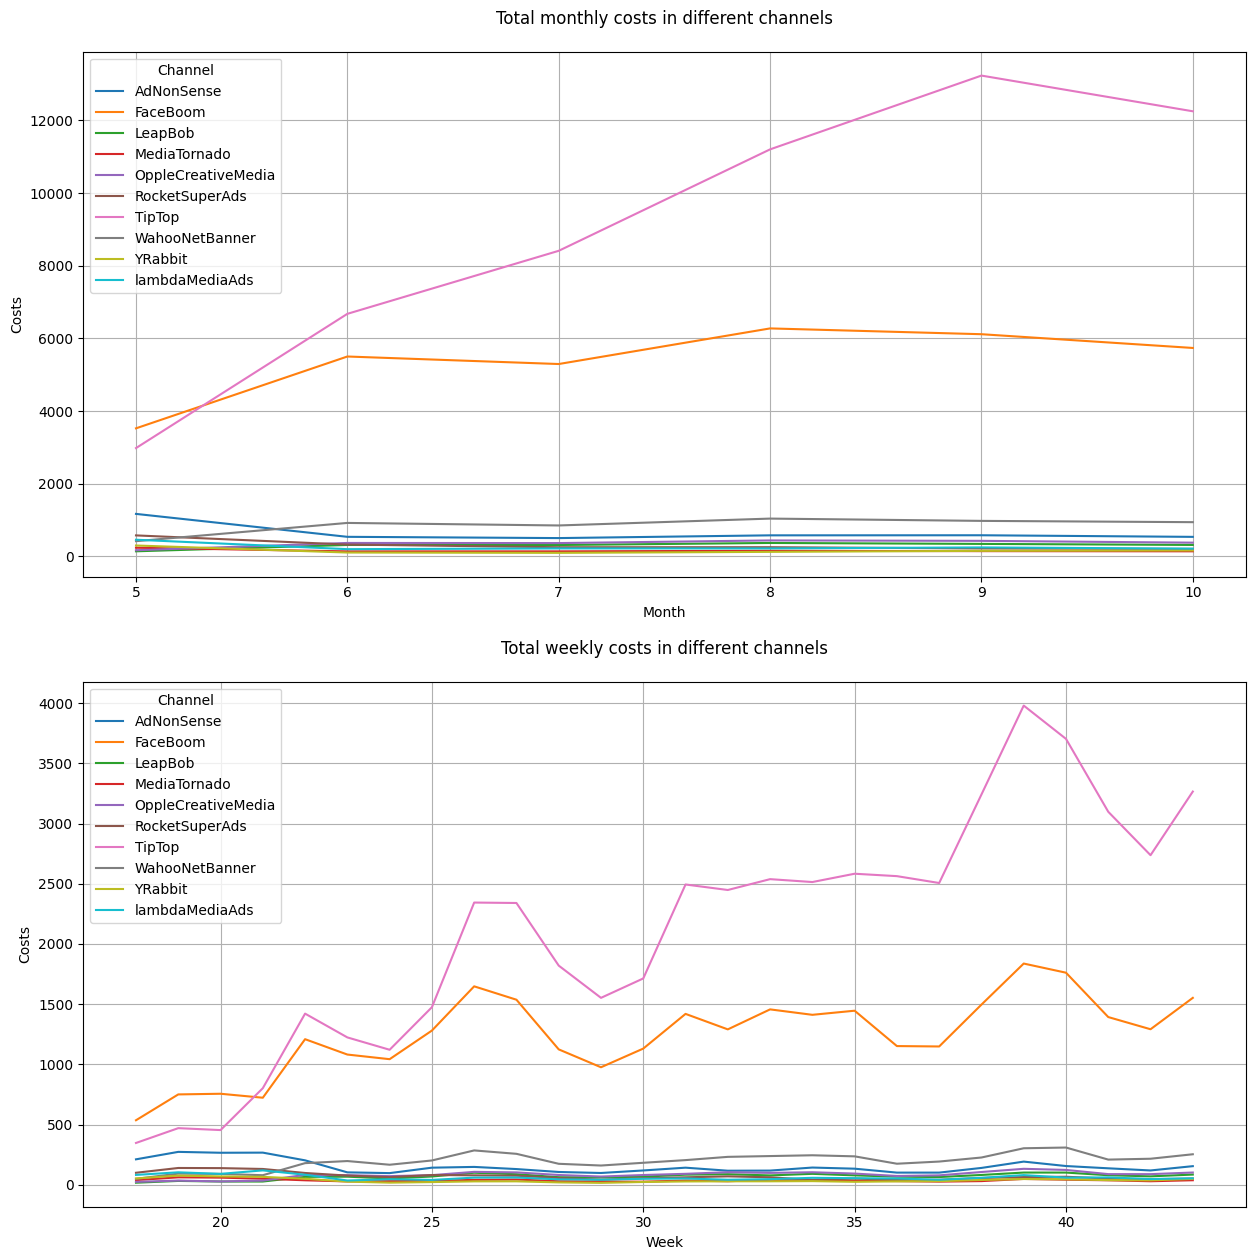

In [119]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

total_monthly_costs = costs.groupby(['channel', 'month']).agg({'costs': 'sum'}).reset_index()
total_weekly_costs = costs.groupby(['channel', 'week']).agg({'costs': 'sum'}).reset_index().astype({'week': 'int64'})

plt.figure(figsize=(15, 15))
sns.set_style({'axes.grid': True})

ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

sns.lineplot(x='month', y='costs', hue='channel', data=total_monthly_costs, ax=ax1)
ax1.set_title('Total monthly costs in different channels', pad=20)
ax1.set_xlabel('Month')
ax1.set_ylabel('Costs')
ax1.legend(loc='upper left', title='Channel')

sns.lineplot(x='week', y='costs', hue='channel', data=total_weekly_costs, ax=ax2)
ax2.set_title('Total weekly costs in different channels', pad=20)
ax2.set_xlabel('Week')
ax2.set_ylabel('Costs')
ax2.legend(loc='upper left', title='Channel')

plt.show()

Over the observed period, the company significantly increased the marketing budget for the TipTop channel. In comparison, the budget increase for the FaceBoom channel was less pronounced. Meanwhile, budgets for other channels remained relatively steady, ranging from 100 to 900 USD per month.

Notably, despite the budget disparities, the FaceBoom channel outperforms the TipTop channel in both conversion rate and attracting new users.

At this juncture, it's valid to question the TipTop channel's effectiveness, especially given its higher budget. *Perhaps reallocating some of TipTop's budget to other channels with better efficiency (lower Customer Acquisition Cost) could yield favorable results.* However, for a conclusive decision, it's essential to calculate the Return on Investment (ROI) and Customer Lifetime Value (LTV) for each user. These metrics will provide a comprehensive understanding and serve as a guide for making informed budget allocation choices.


In [120]:
def show_plot(metric: str, dimensions: list, df_name: str = 'orders', profiles_df: str = 'profiles', window: int = 7):
    result = globals()['get_' + metric](
        profiles=globals()[profiles_df],
        data=globals()[df_name],
        observation_date=observation_date,
        horizon_days=horizon,
        dimensions=dimensions
    )

    globals()[metric + '_plot'](*result[1:], horizon=horizon, window=window)
    

observation_date = datetime(2019, 11, 1).date() # observation date
horizon = 14 # horizon of analysis

profiles = profiles.query('channel != "organic"') # remove organic channel


#### Analysis of conversion

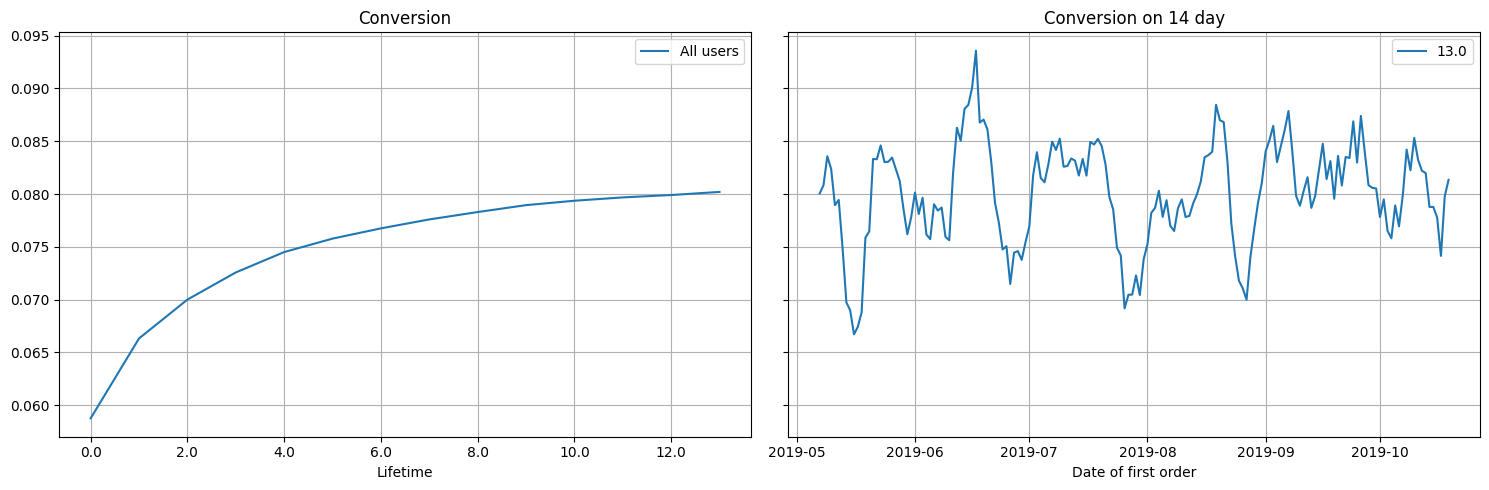

In [121]:

show_plot('conversion',[])

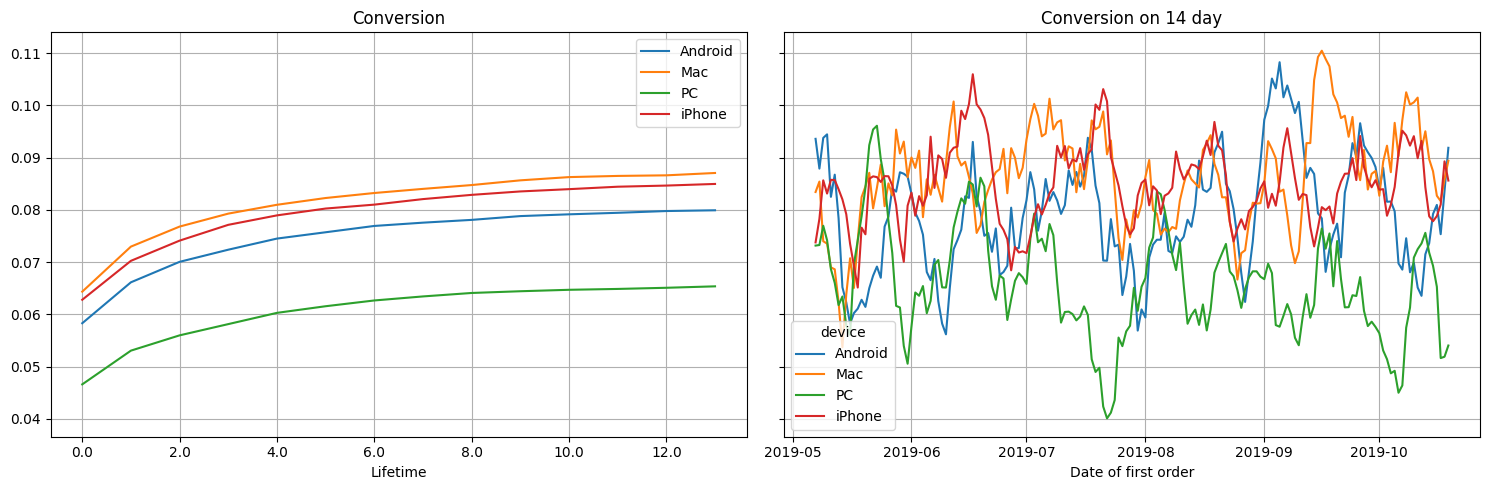

In [122]:

show_plot('conversion', ['device'])


As depicted in the graph above, the conversion rates for users on Mac and iPhone devices surpass those of users on Android devices. Conversely, PC users exhibit the lowest conversion rate. 

Now, let's proceed to examine the conversion rates across different marketing channels.

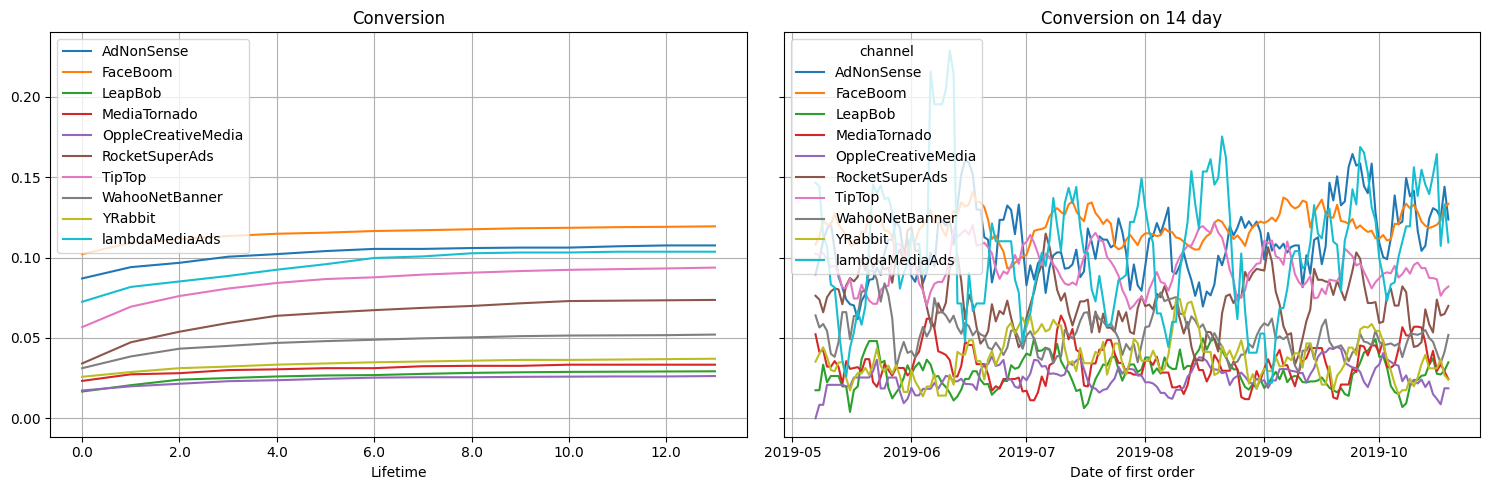

In [123]:
show_plot('conversion', ['channel'])

The highest conversion rates are observed within the following top three channels:

1. FaceBoom
2. AdNonSense
3. lambdaMediaAds

Notably, TipTop ranks fourth in terms of conversion rate.

With this insight in mind, let's shift our focus to examine the conversion rates by country.

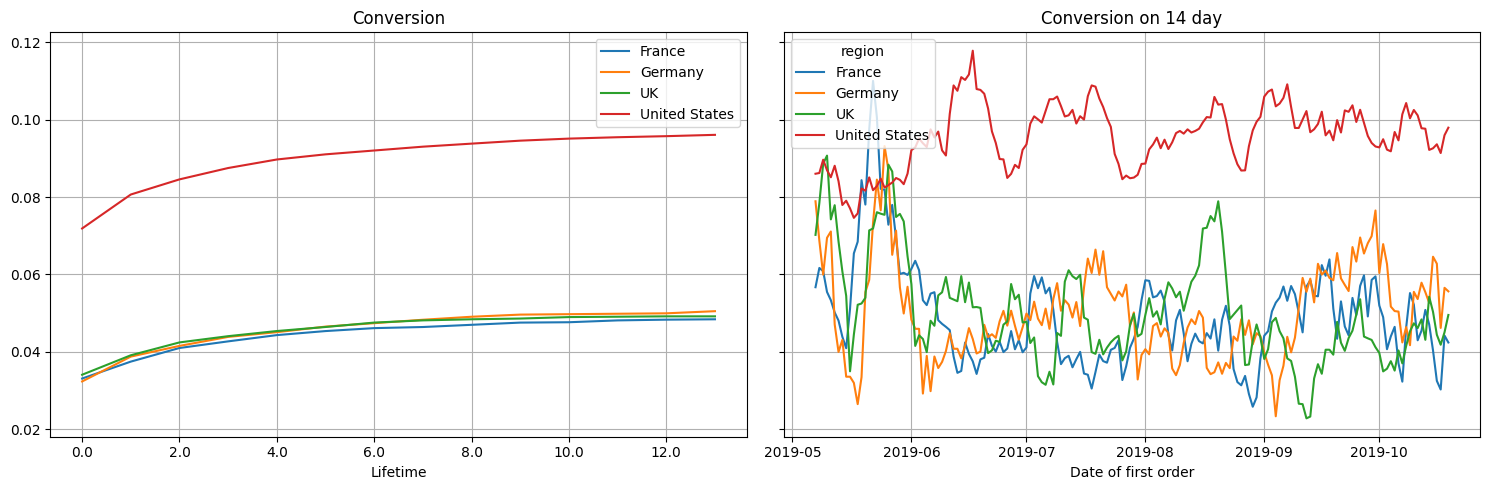

In [124]:
show_plot('conversion', ['region'])

Given the substantial budget allocation to the US market, it's not surprising to find that the conversion rate there is the highest. However, the conversion rates in other countries are comparatively lower. This correlation between budget allocation and conversion rate underscores the influence of investment in driving successful outcomes.

#### Analysis of retention

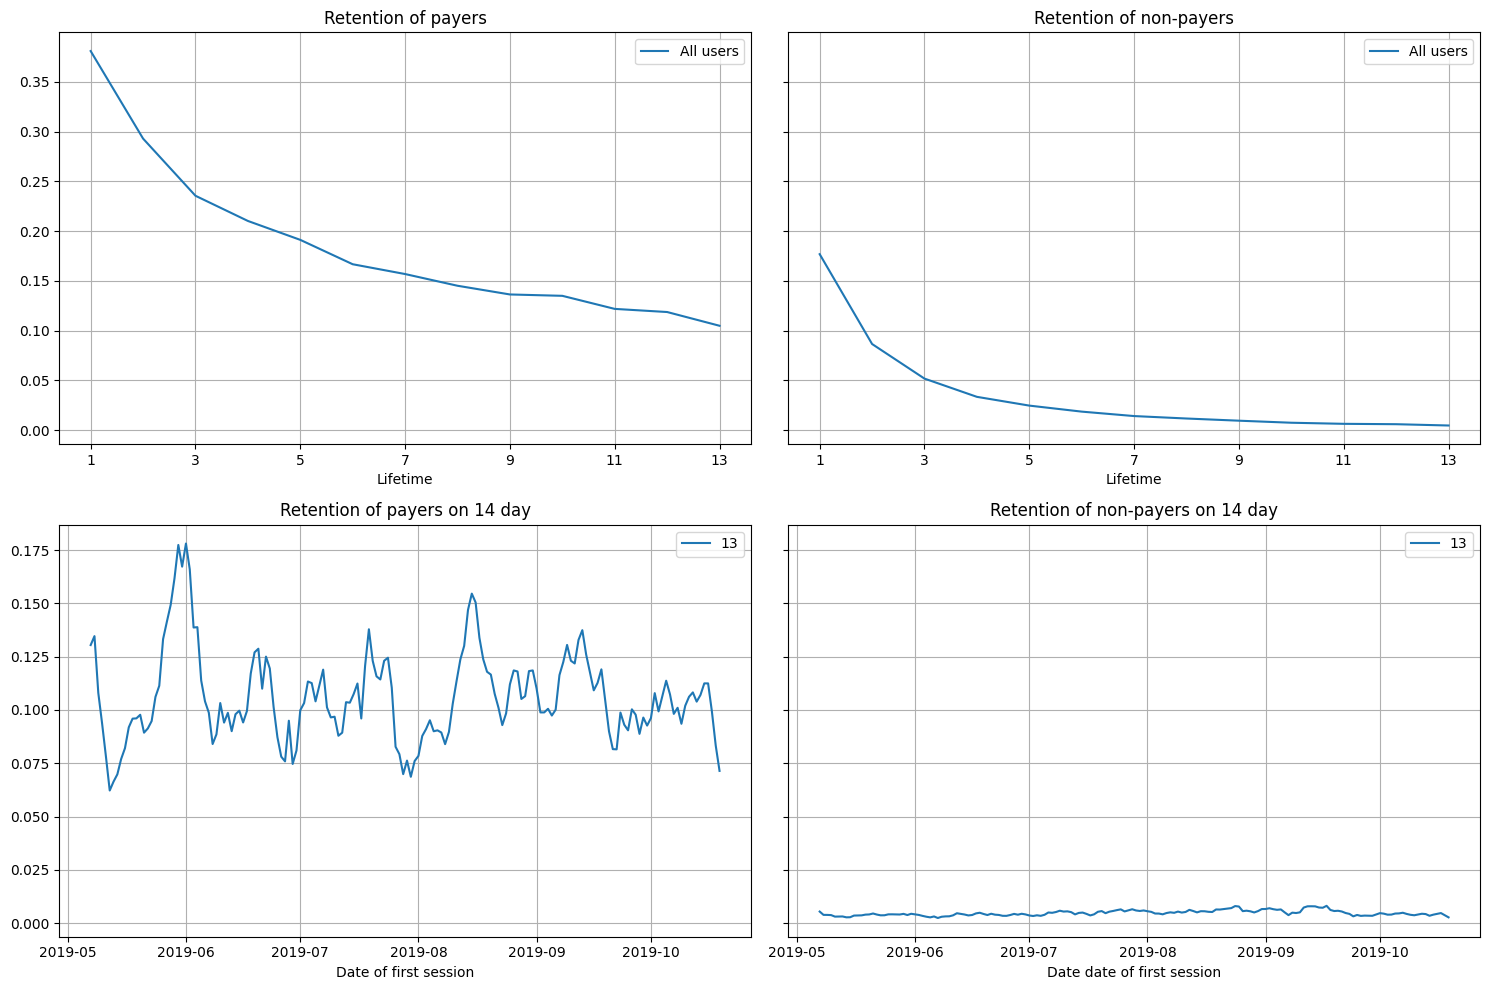

In [125]:
show_plot('retention', [], 'visits')

Retention of payers is bigger than retention of non-payers. This is expected, as users who have already made a purchase are more likely to continue engaging with the platform.

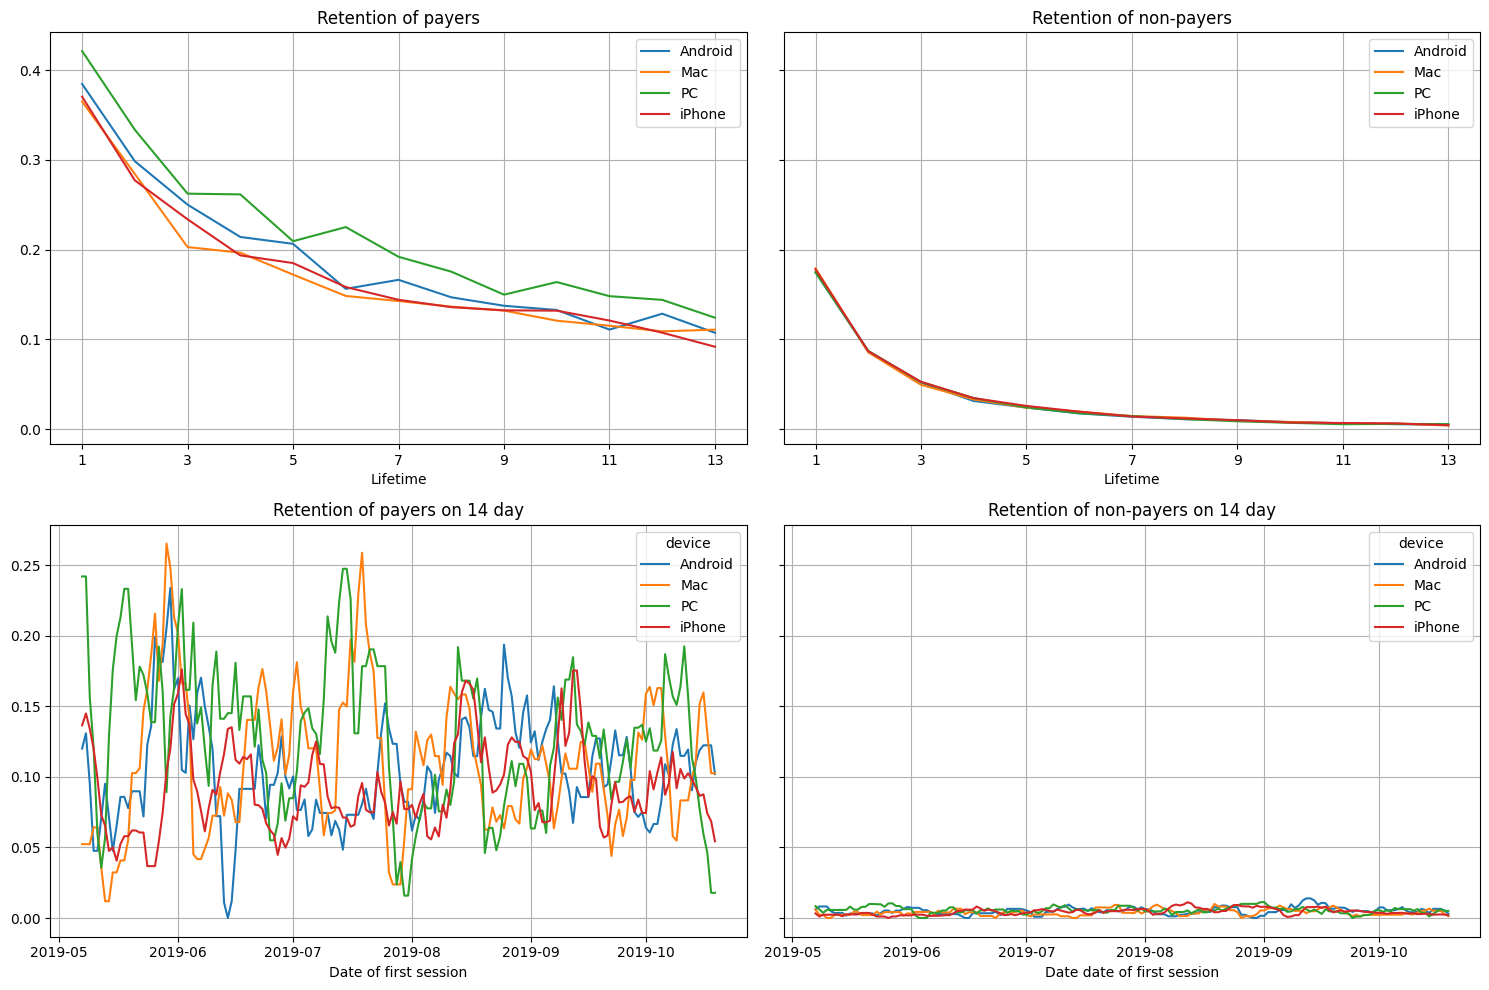

In [126]:
show_plot('retention', ['device'], 'visits')

An intriguing finding emerges when examining user retention based on device usage. Surprisingly, the highest retention rate is observed among paying users who utilize PCs, while the lowest retention rate is associated with iPhone users. 

This observation adds an interesting layer of insight. Previously, we noted that the conversion rate for PC users was the lowest. However, this data suggests that although PC users are less prone to conversion, those who do convert exhibit a greater likelihood of sustained engagement with the platform. This underscores the nuanced relationship between conversion and long-term user commitment.

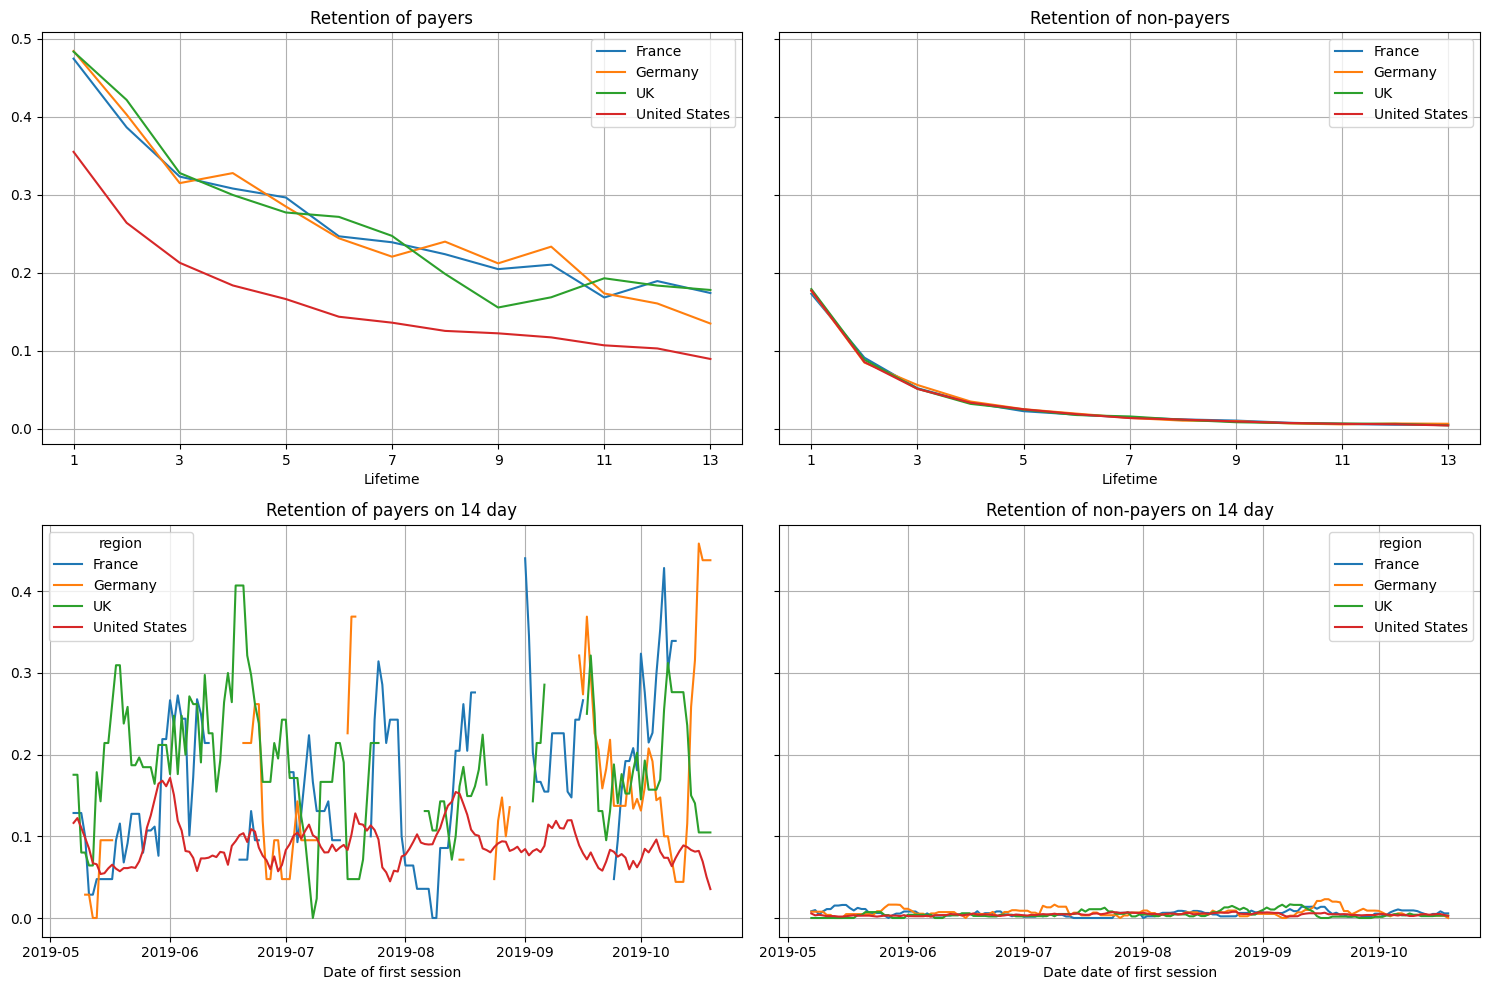

In [127]:
show_plot('retention', ['region'], 'visits')

The retention rate in the US is lower compared to other countries. This seems contradictory considering the US market's strong conversion rate.

One possible explanation is the intense competition in the US market. With numerous options available, users might be more inclined to explore other alternatives, resulting in the observed lower retention rate. Another factor to consider is that US users primarily use Apple devices, which tend to have a relatively lower retention rate.

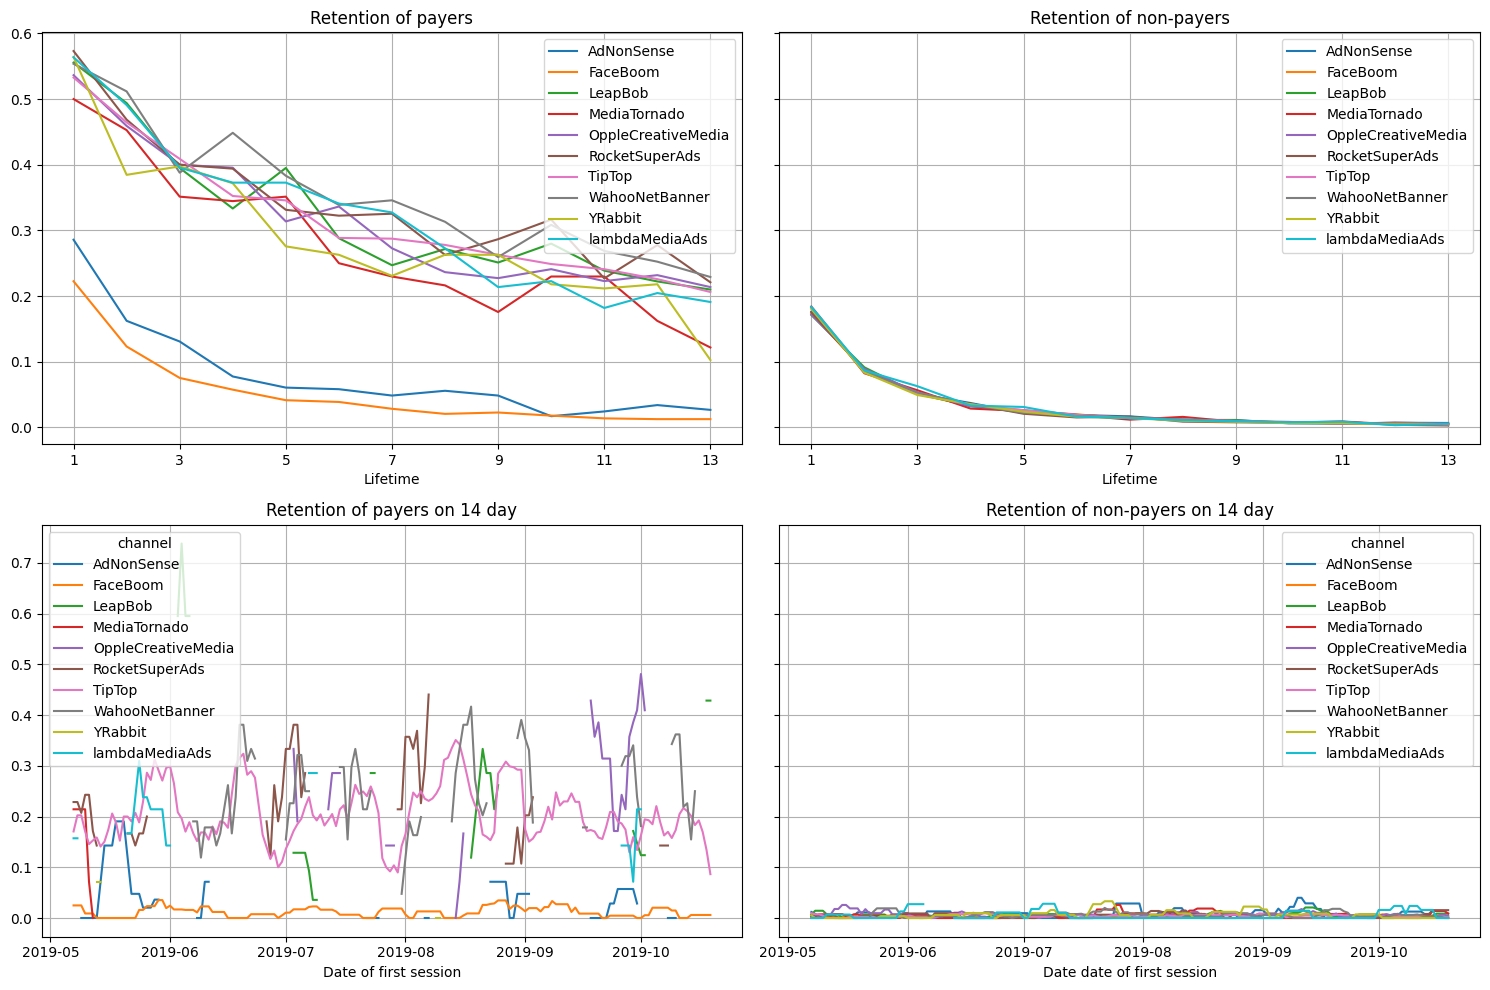

In [128]:
show_plot('retention', ['channel'], 'visits')

Key takeaways from the provided graphs are as follows:

- The retention rate experiences a decline over the observed period for both paying and non-paying users.
- Paying users exhibit a higher retention rate compared to non-paying users. This aligns with expectations, considering that paying users are typically more invested in the product.
- The retention rate in USA is notably the lowest among all countries, which contrasts with its high initial conversion rate.
- Notably, the FaceBoom channel demonstrates the poorest retention rate, closely followed by AdNonSense.

#### Analysis of LTV and ROI

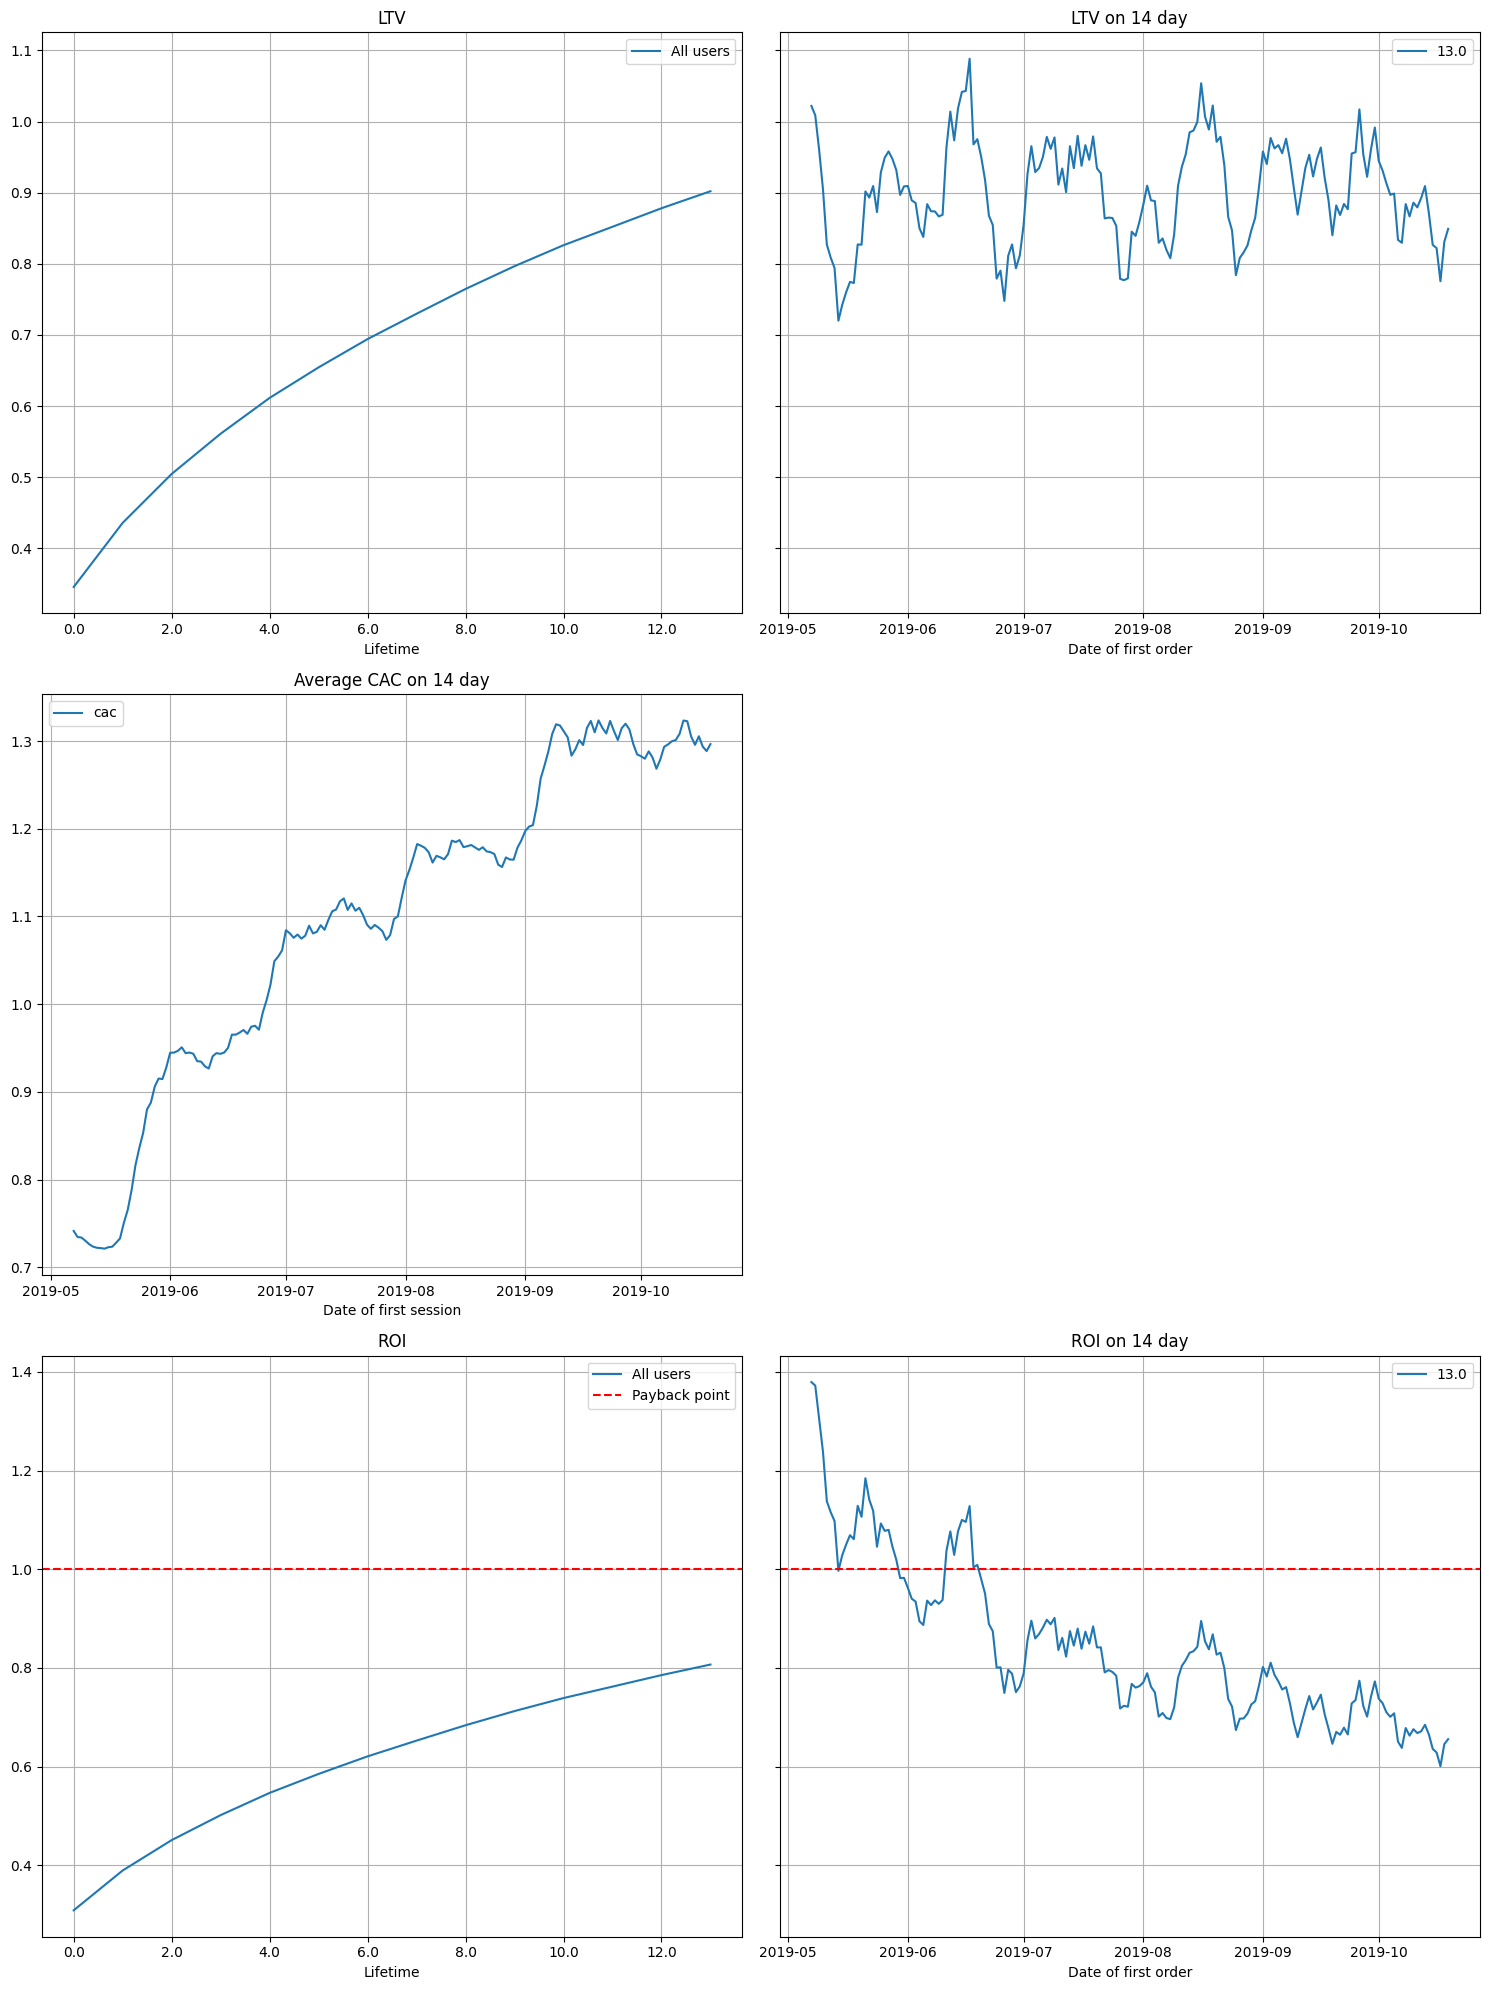

In [129]:
show_plot('ltv_and_roi', [])

Key observations gleaned from the comprehensive LTV and ROI analysis graphs are as follows:

- The Lifetime Value (LTV) exhibits volatility while consistently maintaining a certain range.
- The Customer Acquisition Cost (CAC) displays a gradual increase over the observed period.
- The Return on Investment (ROI) fails to reach the payback point within the span of two weeks.
- Furthermore, the ROI demonstrates a declining trend during the course of the observations.

Let's dive in deeper to examine the LTV and ROI for each dimensions

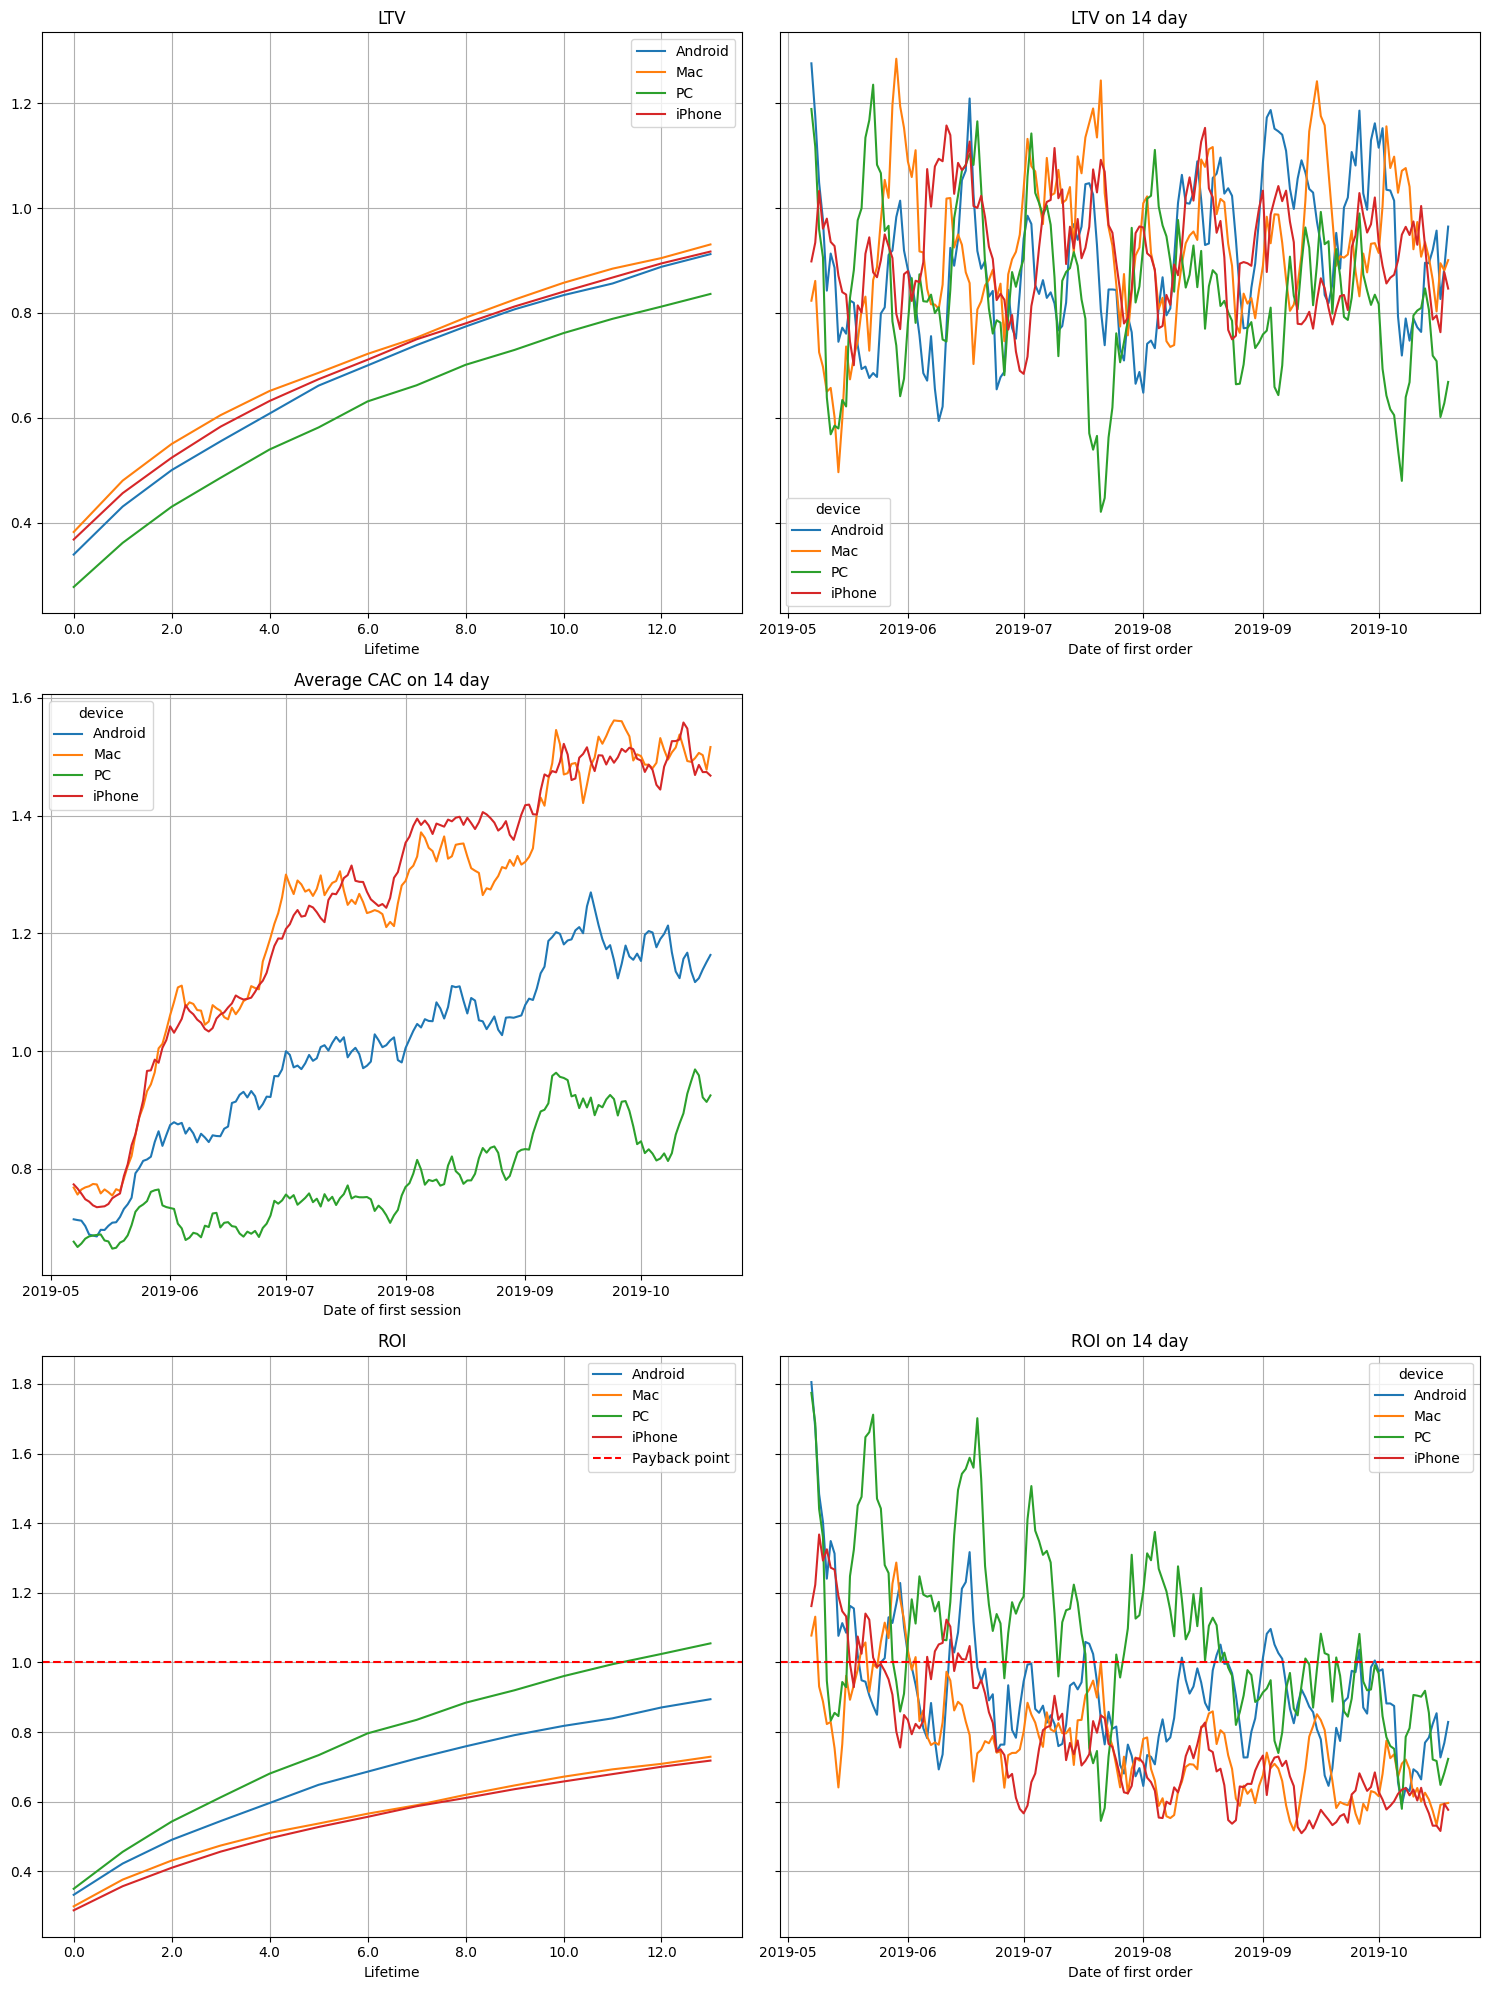

In [130]:
show_plot('ltv_and_roi', ['device'])

PC users are notably the only group achieving payback level on the 11th day, indicating a faster return on investment for this group.
Conversely, other device users do not experience payback within the observed period, with Mac and iPhone users showcasing the lowest ROI.
Furthermore, the overall CAC trend for each device demonstrates an upward trajectory over the analyzed period. Notably, Mac users exhibit the highest CAC, whereas PC users have the lowest CAC.

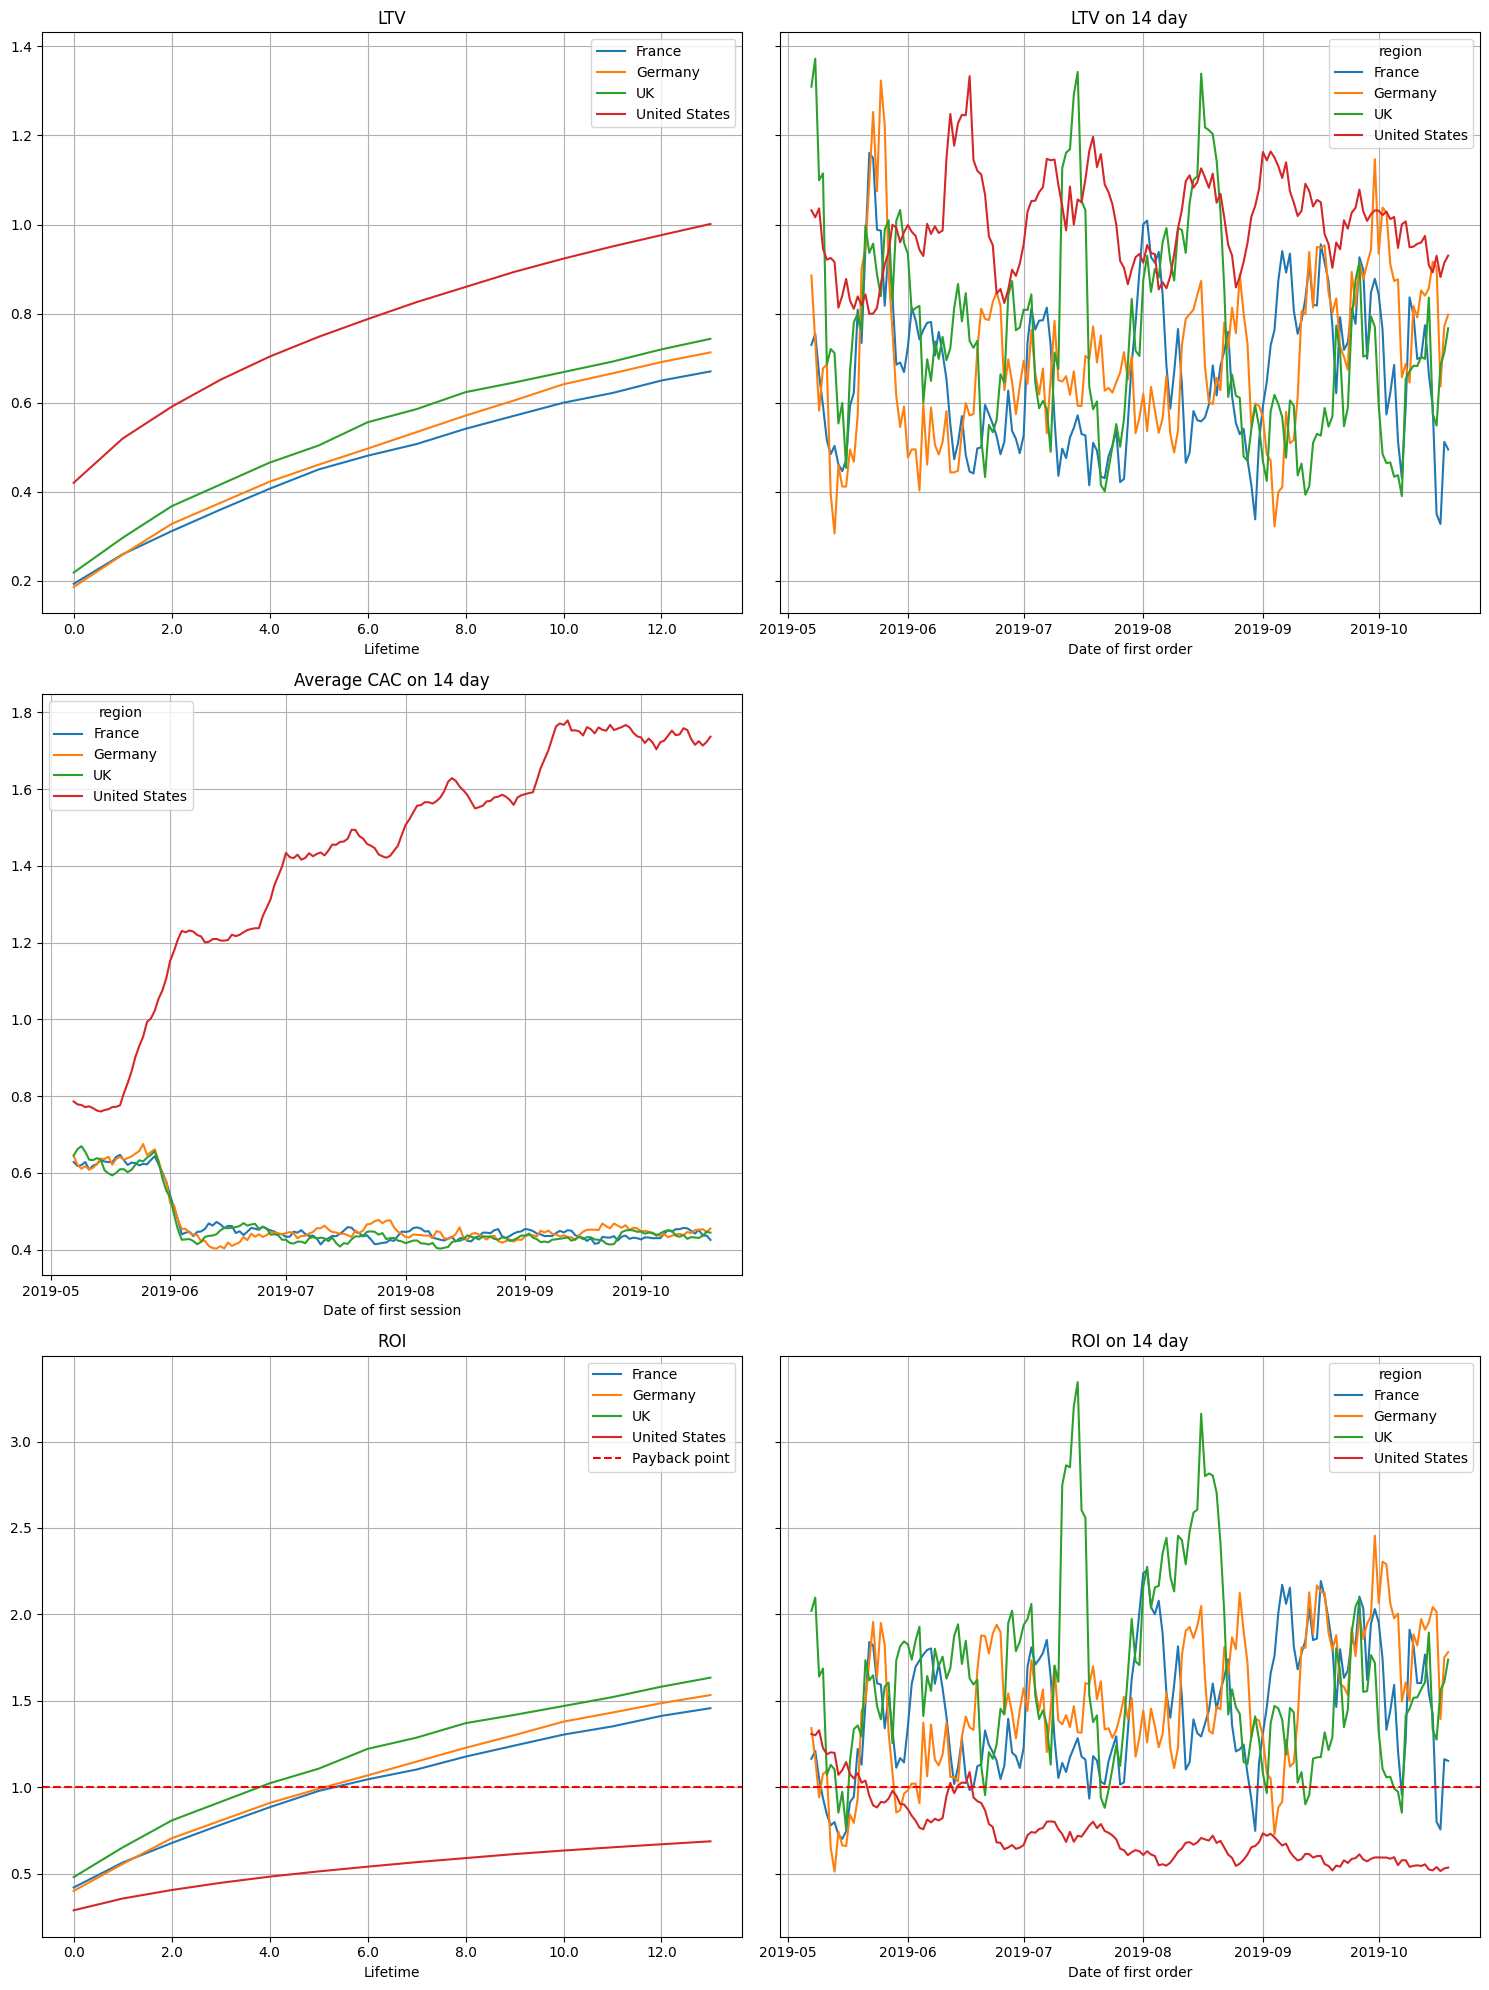

In [131]:
show_plot('ltv_and_roi', ['region'])

LTV of the US users is the highest, and differs significantly from other countries. At the same time CAC is also the highest for US users. Which leads to the ROI of US users being the lowest among all countries.

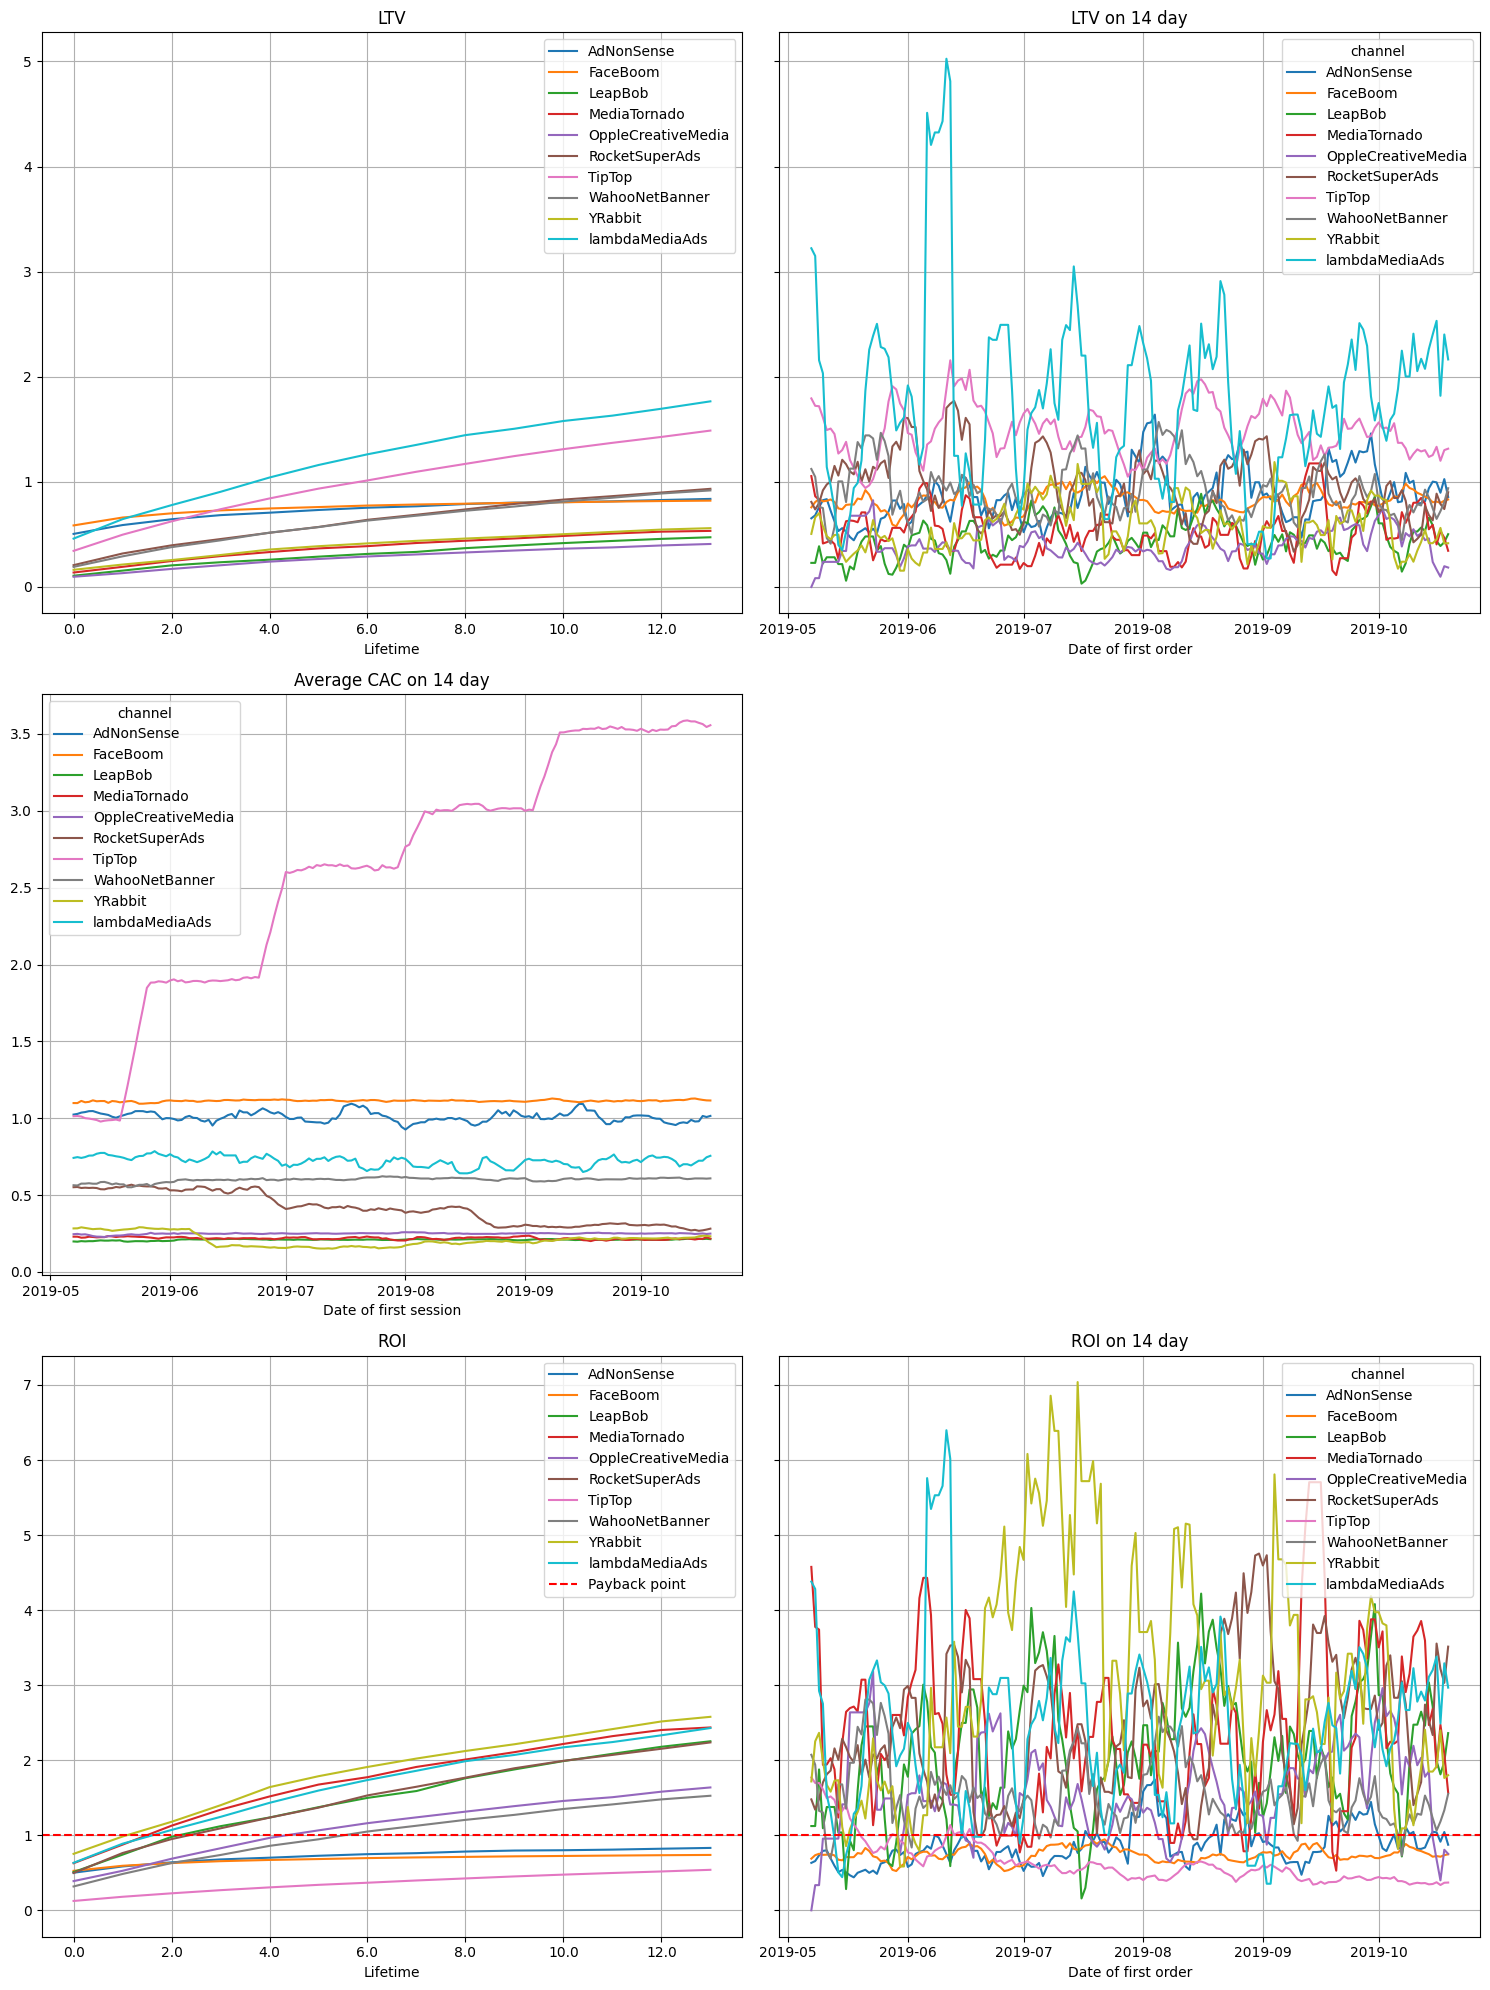

In [132]:
show_plot('ltv_and_roi', ['channel'])

Among various channels, users from lambdaMediaAds channel exhibit the most impressive Lifetime Value (LTV). In contrast, FaceBoom's LTV is not as remarkable as anticipated.
TipTop holds the second-best position in terms of LTV, but it's accompanied by the highest Customer Acquisition Cost (CAC) among all channels. Notably, TipTop's CAC consistently rises throughout the observation period, increasing by approximately 0.5 USD per month.
Unfortunately, both TipTop and FaceBoom fail to reach payback during the observation period, suggesting an inability to cover initial investments.
In contrast, lambdaMediaAds stands out with an exceptional achievement – reaching payback as early as the second day.

## 5. Intermediate Conclusion

#### Identified Challenges

Throughout the analysis, several significant challenges have been brought to light:

- A substantial portion of the marketing budget is directed towards FaceBoom and TipTop channels, which demonstrate suboptimal efficiency.
- The entire marketing campaign fails to achieve payback within the observation period (2 weeks).
- The Customer Acquisition Cost (CAC) shows a consistent increase, with particularly rapid growth in the competitive US market.
- Retention rates for both paying and non-paying users exhibit a decline over the observed period.
- Users who predominantly use Mac and iPhone devices, constituting a major segment, do not achieve payback during the observation period and also display low retention rates.


#### Let's delve into deeper analysis to identify the root causes of these challenges.

Firstly, let's remove the TipTop channel which is showing low results, from the data to check if the results will change. 

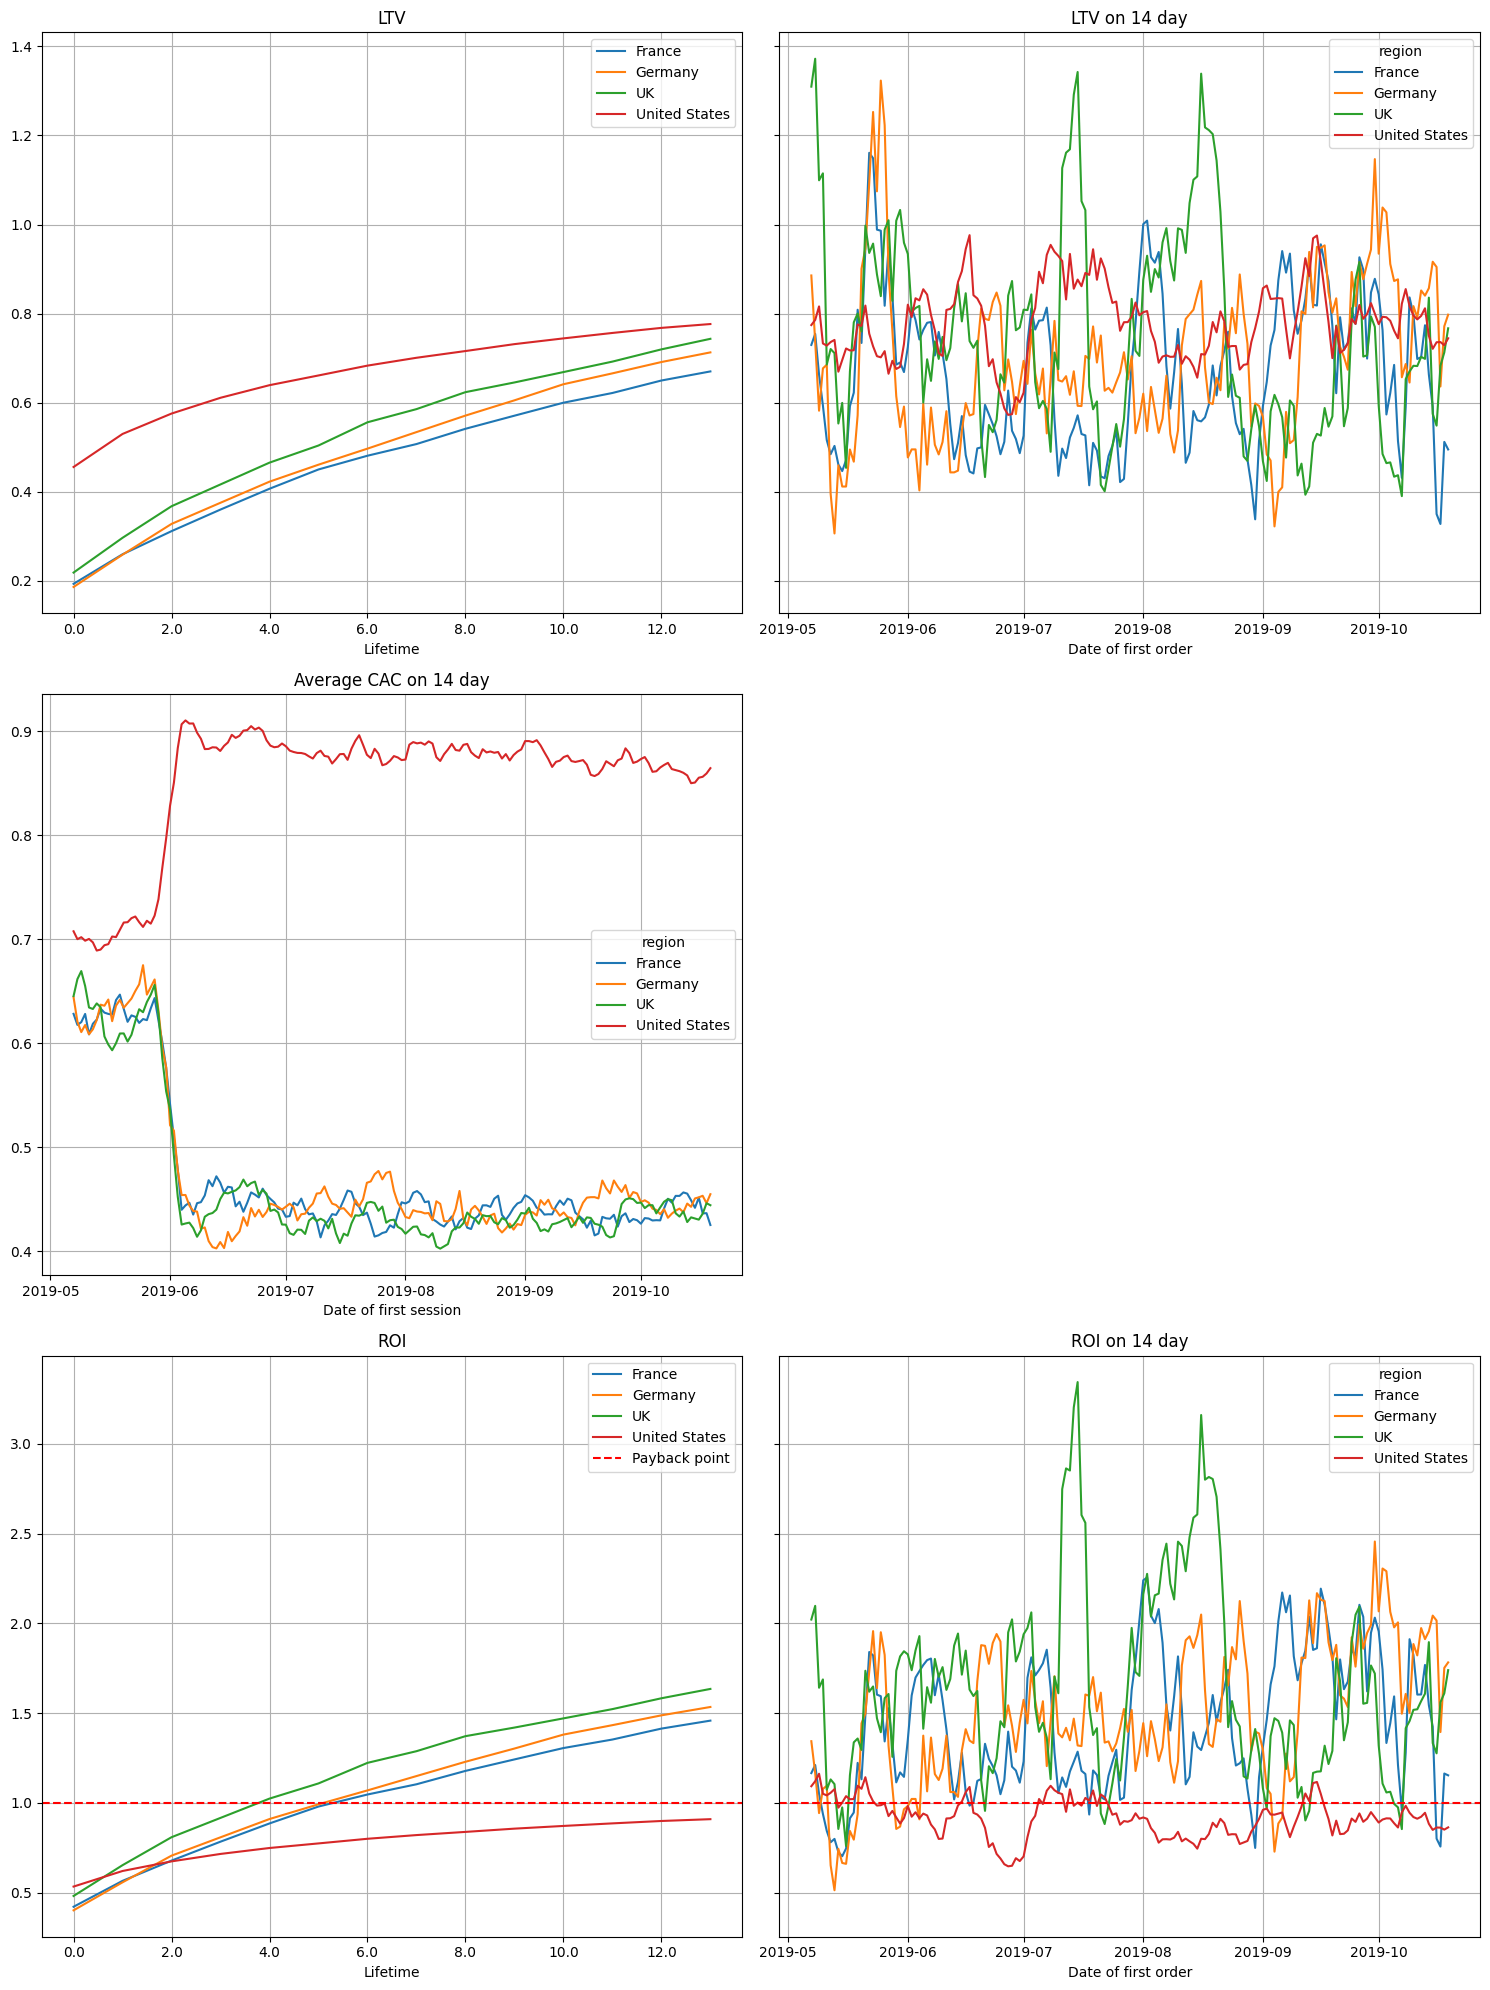

In [133]:
profiles_wo_tiptop = profiles.query('channel != "TipTop"')
show_plot('ltv_and_roi', ['region'], profiles_df='profiles_wo_tiptop')

Removing the TipTop channel has brought about significant changes, particularly in the US market. The reduction in Customer Acquisition Cost (CAC) and the proximity to the payback point indicate that without TipTop, the US market is showing better efficiency and faster returns.

However, the European market still holds untapped potential even after excluding TipTop. This suggests that further efforts and adjustments could lead to positive outcomes in this market.


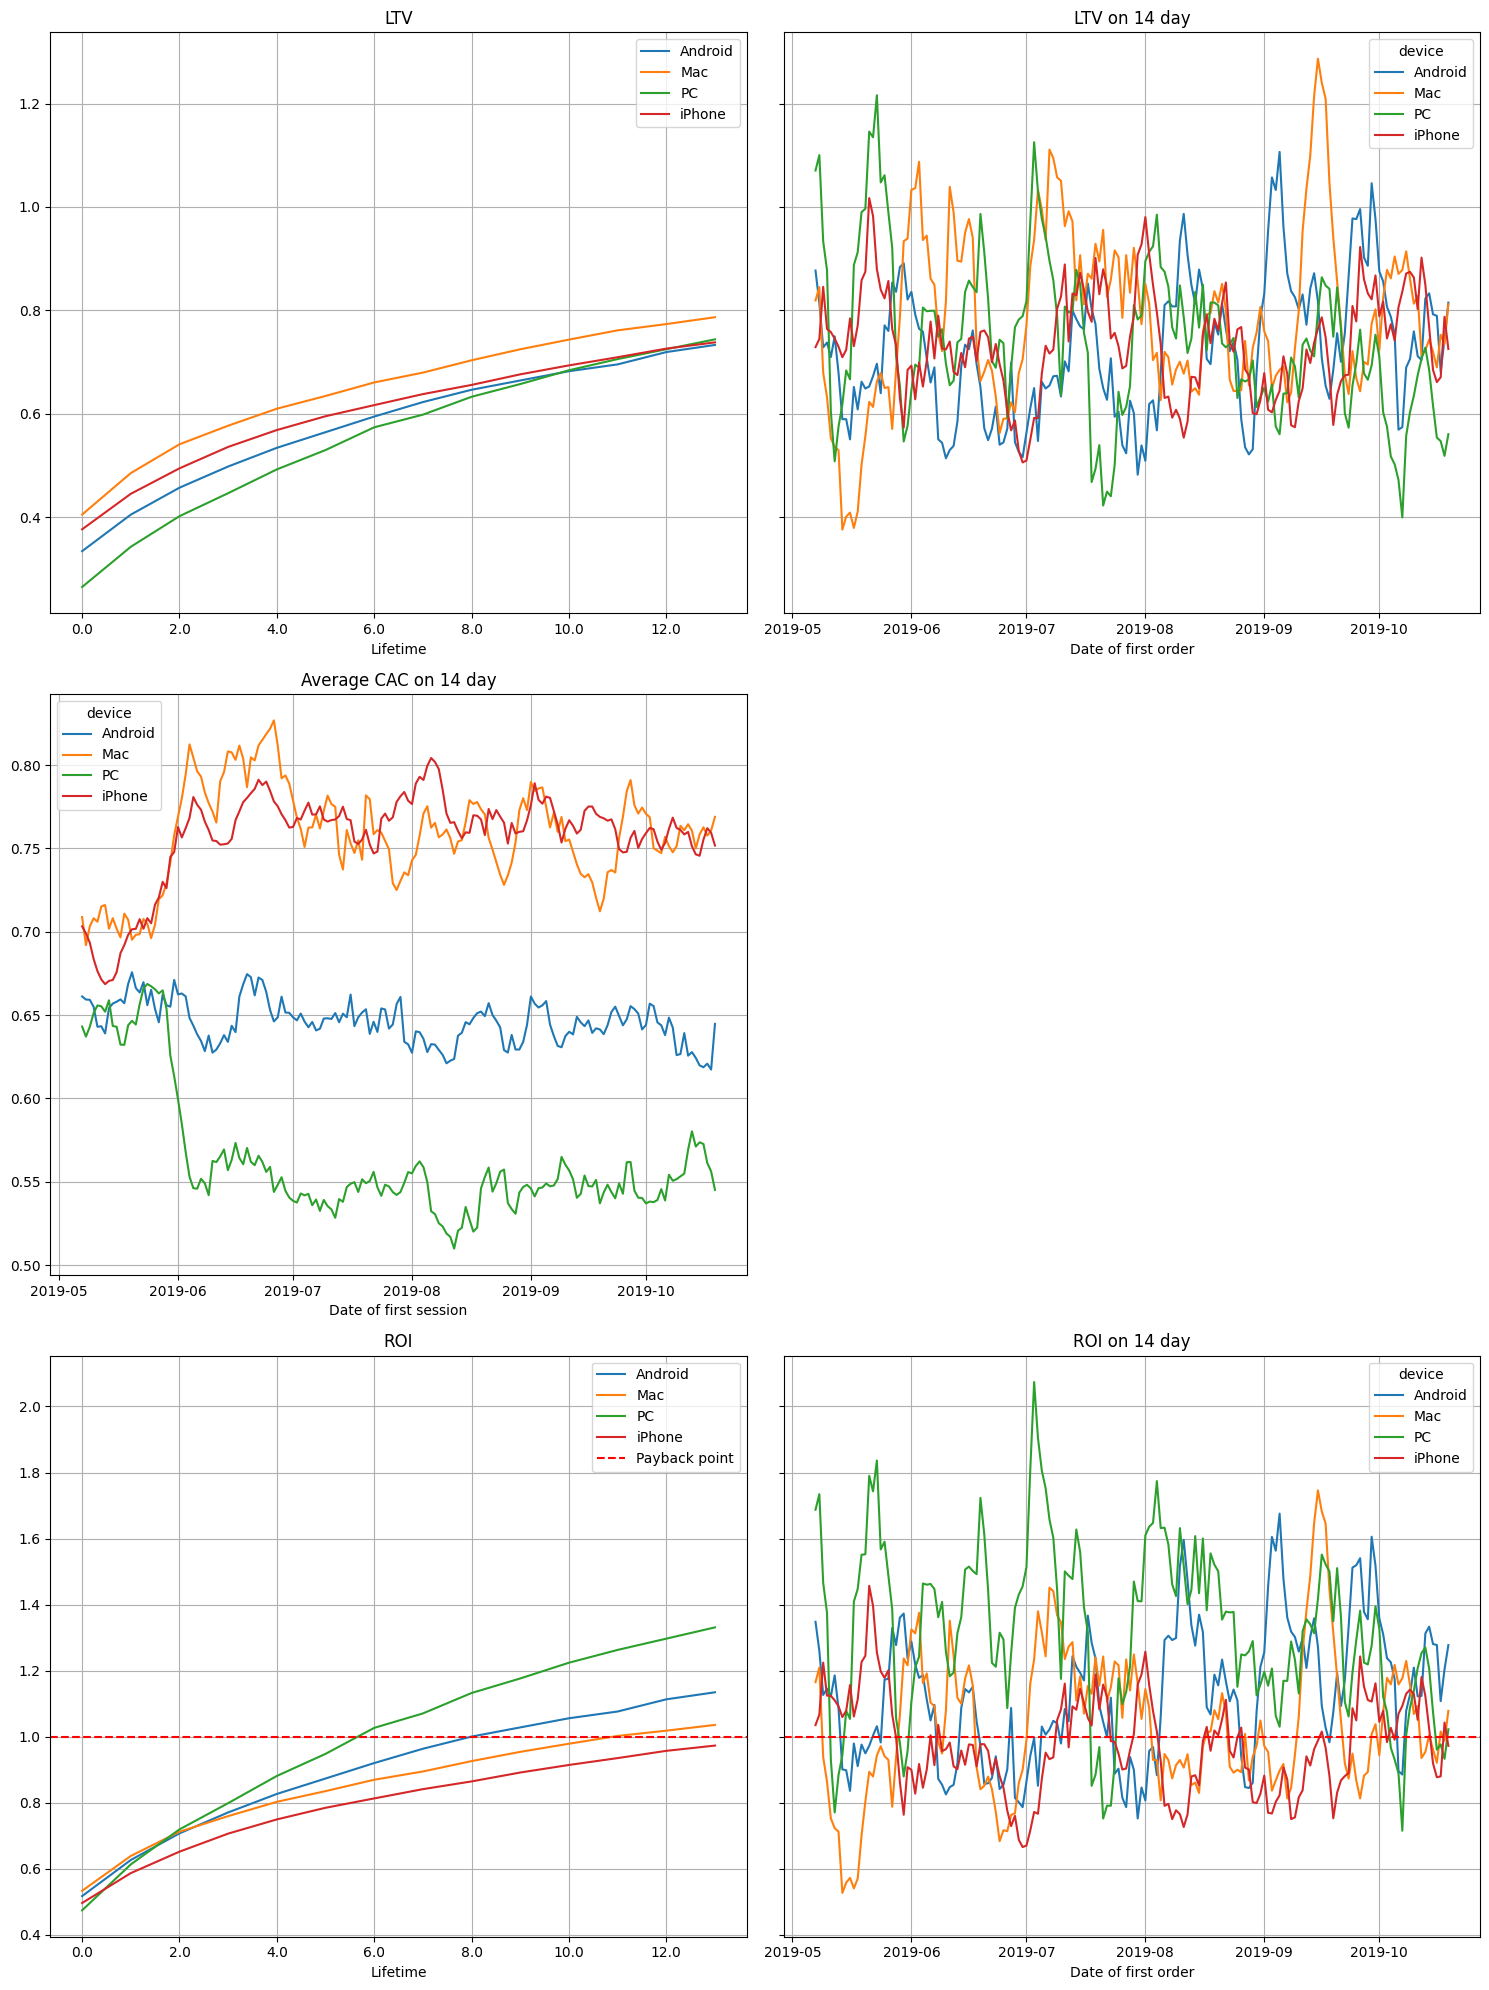

In [134]:
show_plot('ltv_and_roi', ['device'], profiles_df='profiles_wo_tiptop')

Targeting PC users emerges as the most cost-effective strategy in terms of Return on Investment (ROI). While their Lifetime Value (LTV) is comparable to users on other devices, PC users exhibit the lowest Customer Acquisition Cost (CAC).

Let's dive into analysis of the US market because the most users of Iphone is from there.

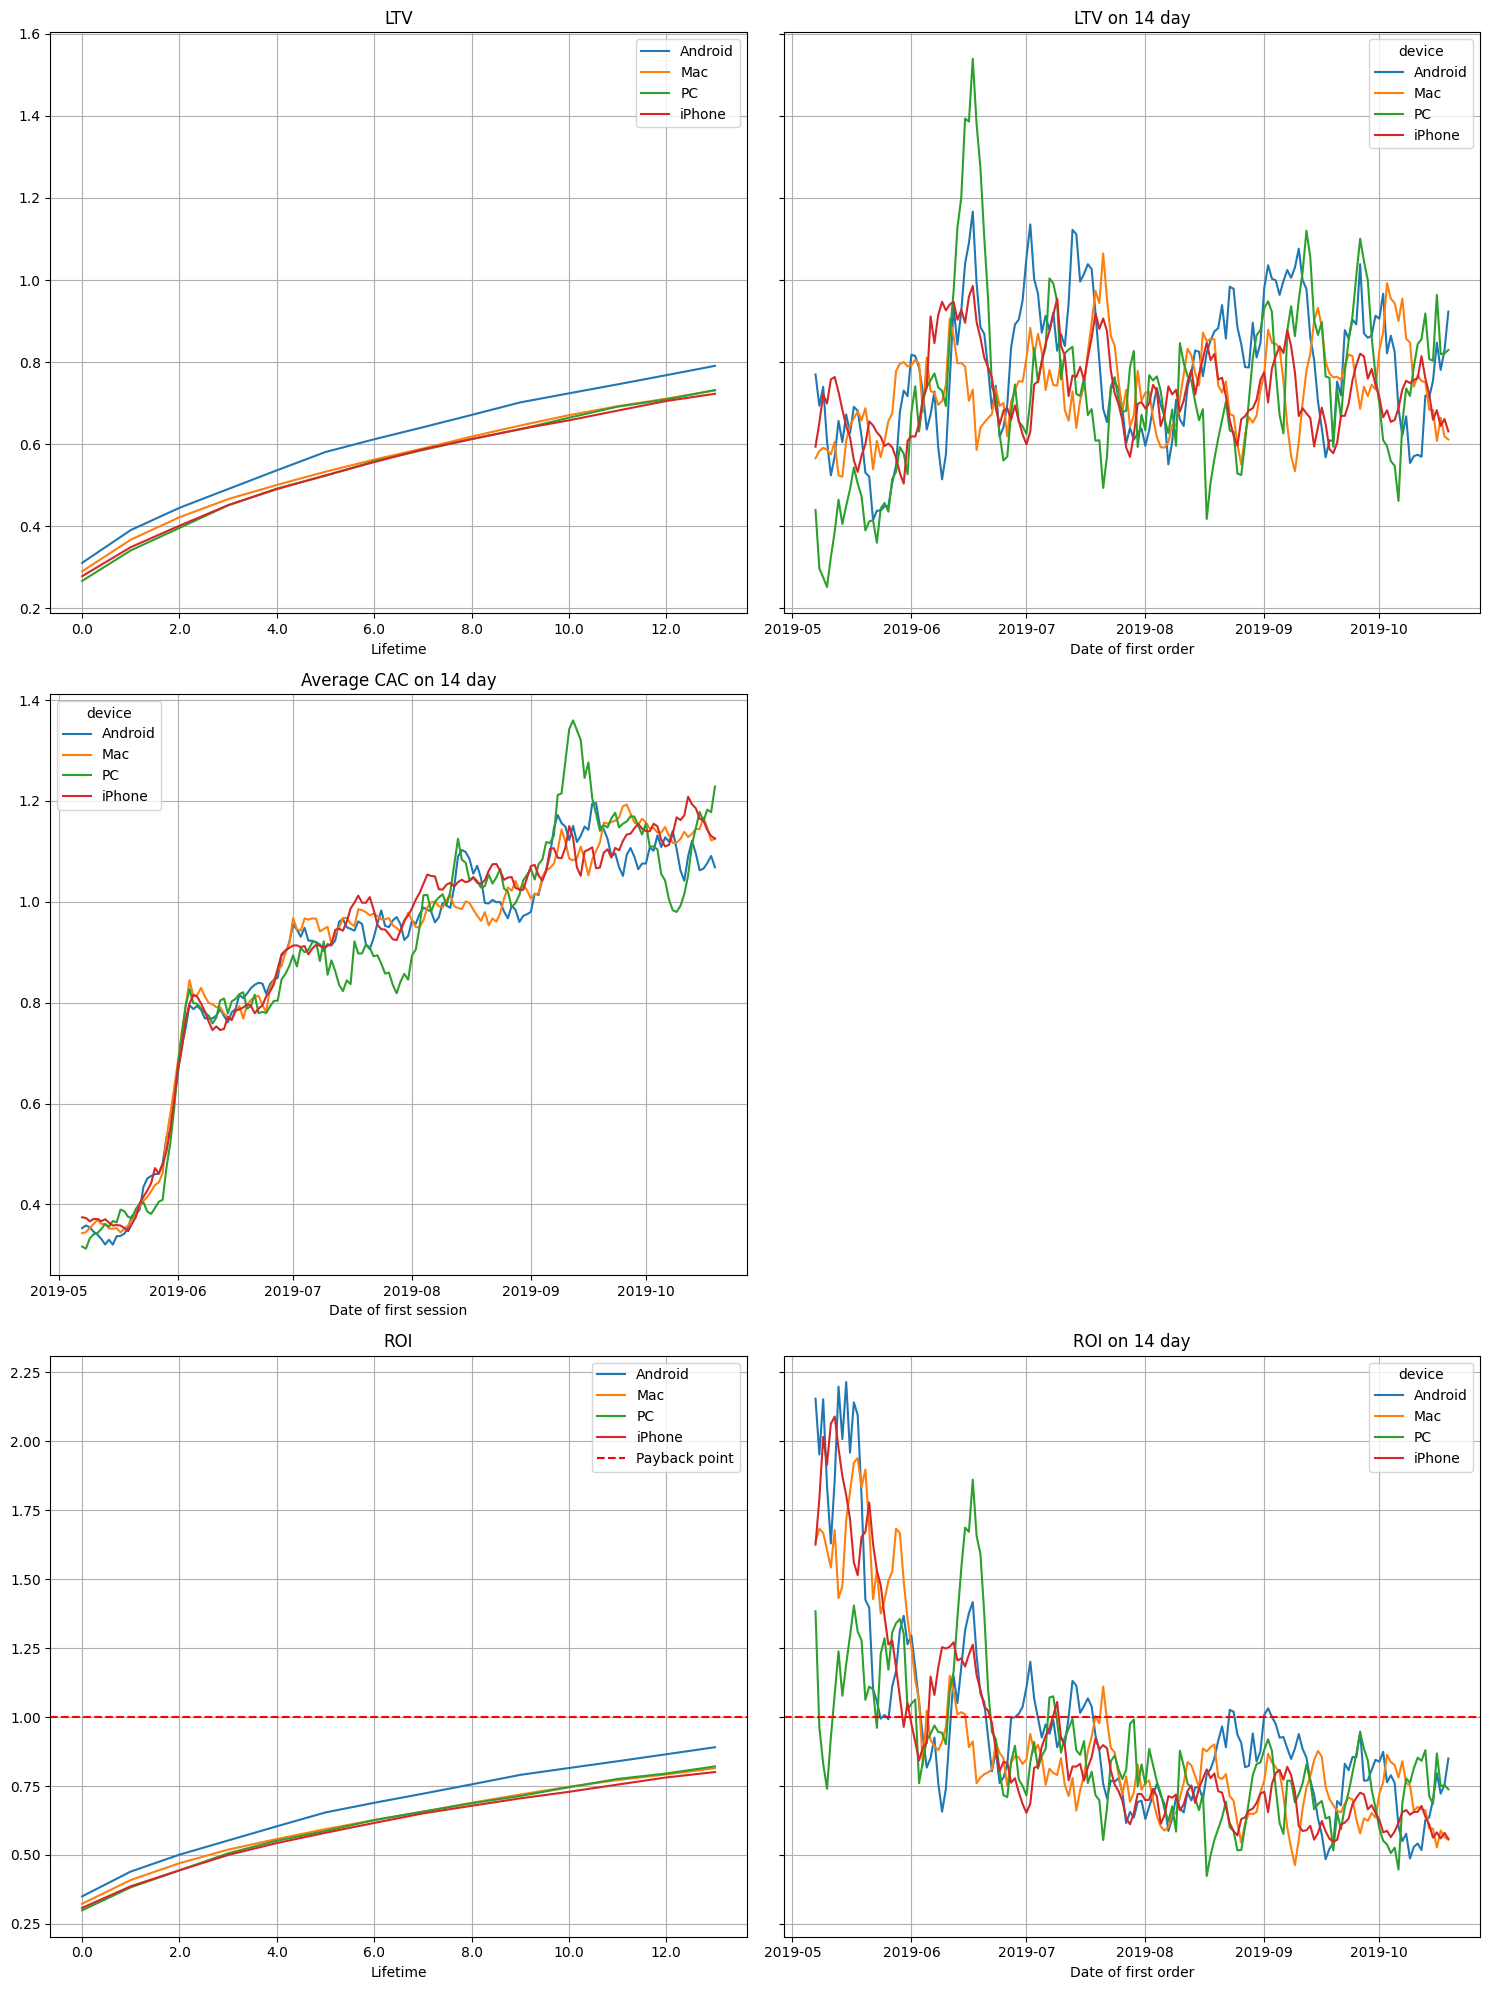

In [135]:
visits_us = visits.query('region == "United States"')
profiles_us = get_profiles(visits=visits_us, orders=orders, costs=costs)

show_plot('ltv_and_roi', ['device'], profiles_df='profiles_us')

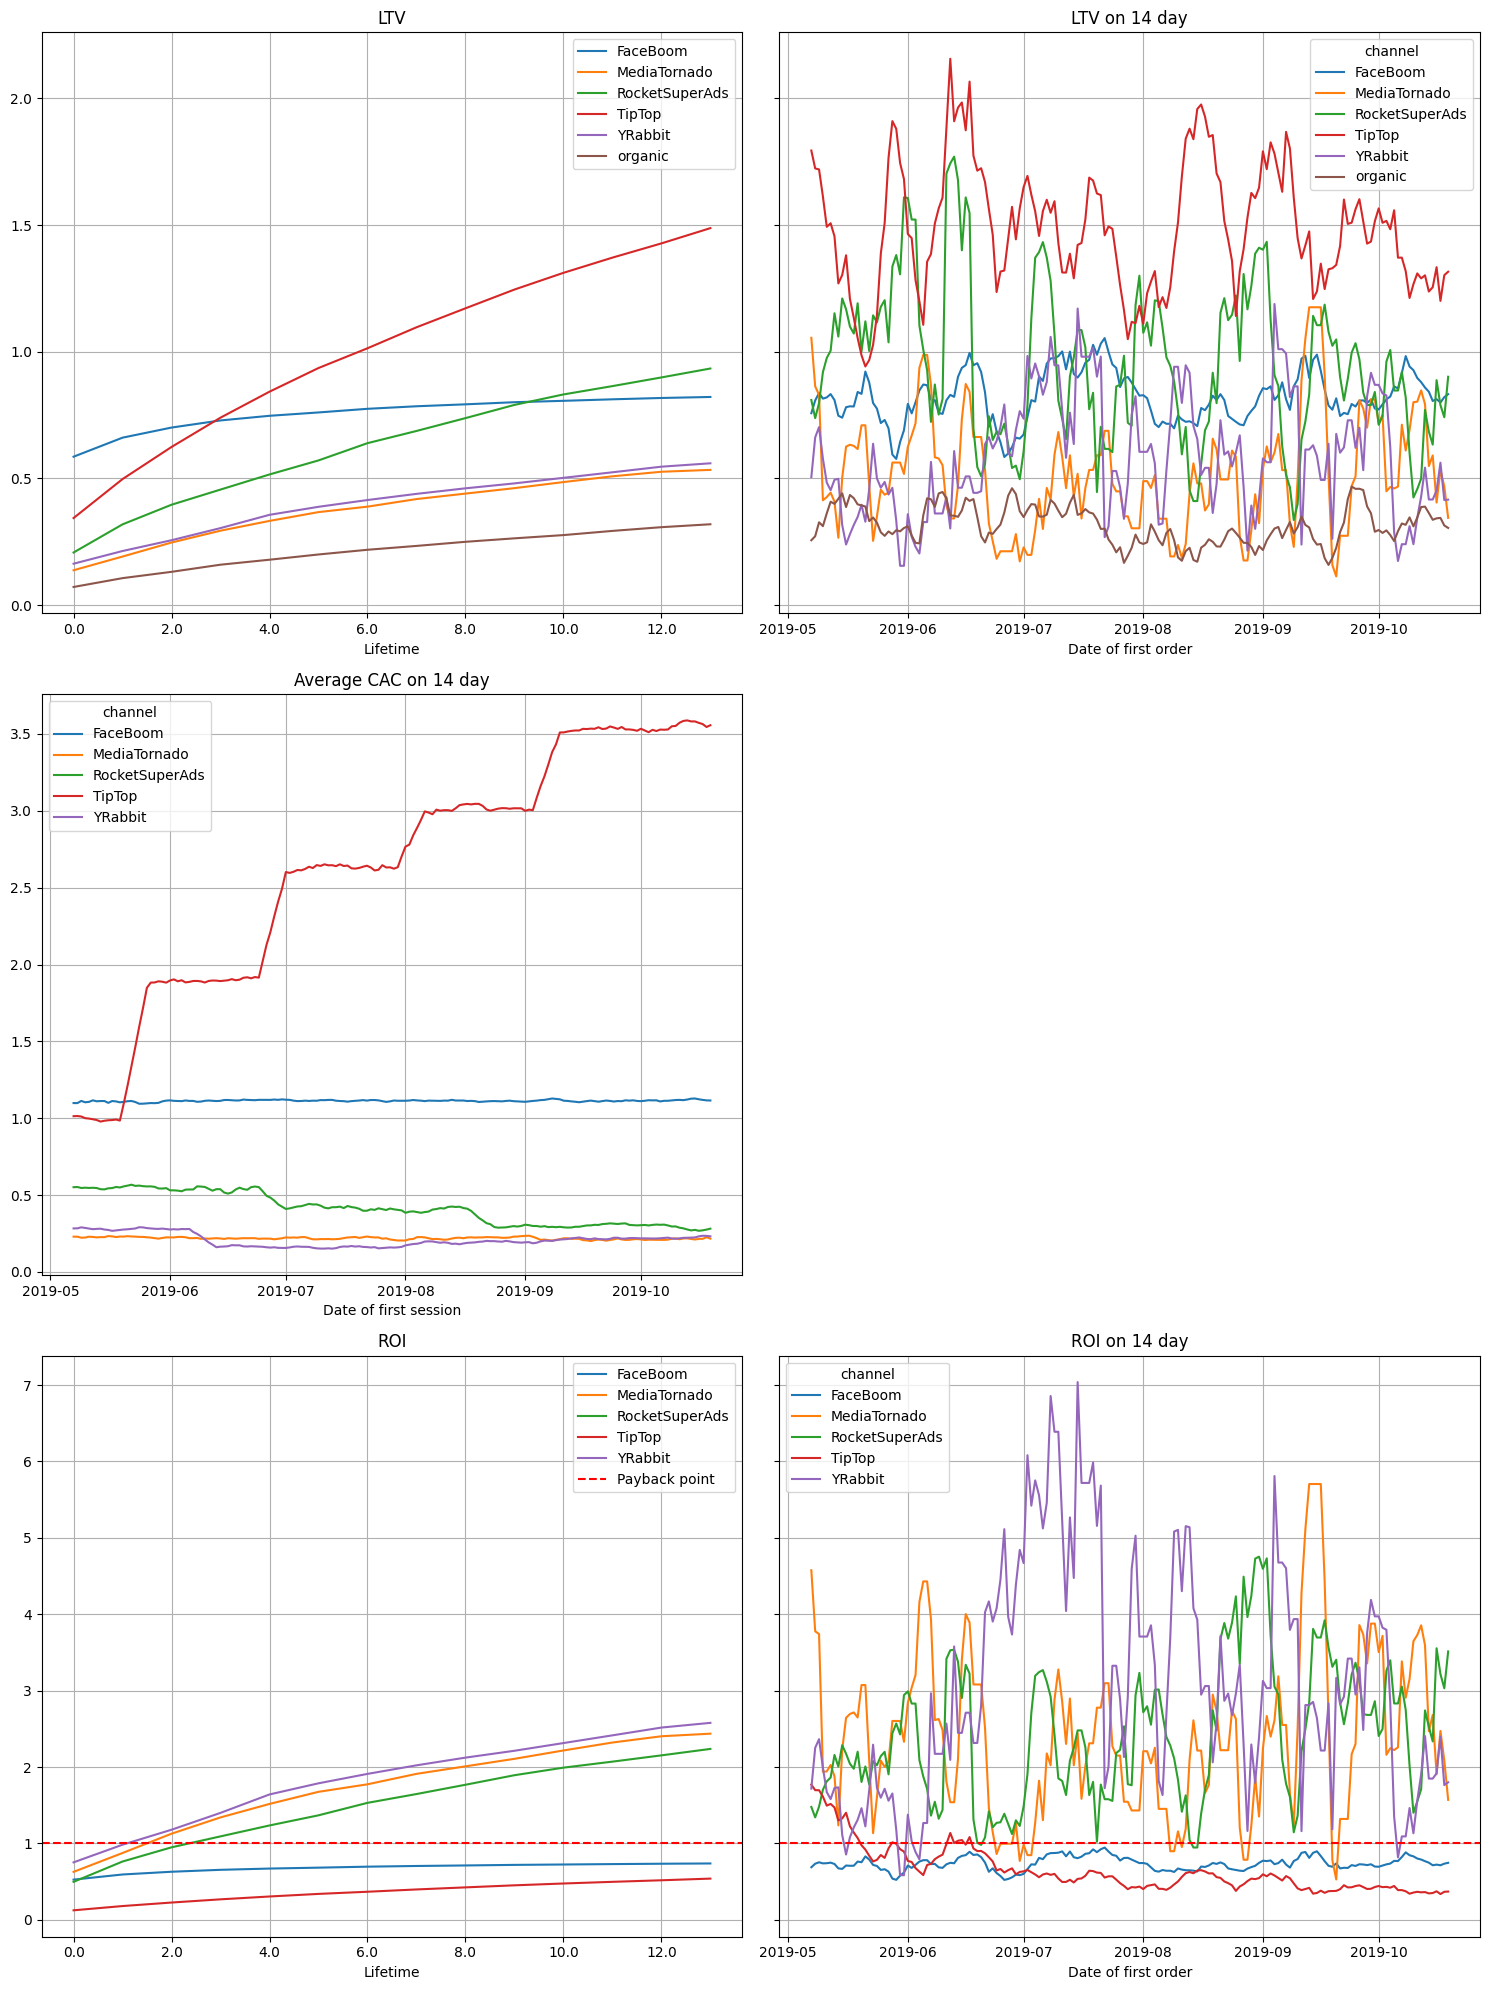

In [136]:
show_plot('ltv_and_roi', ['channel'], profiles_df='profiles_us')

We can again find out that TipTop is influencing the results in a bad way. Let's remove it from the US data.


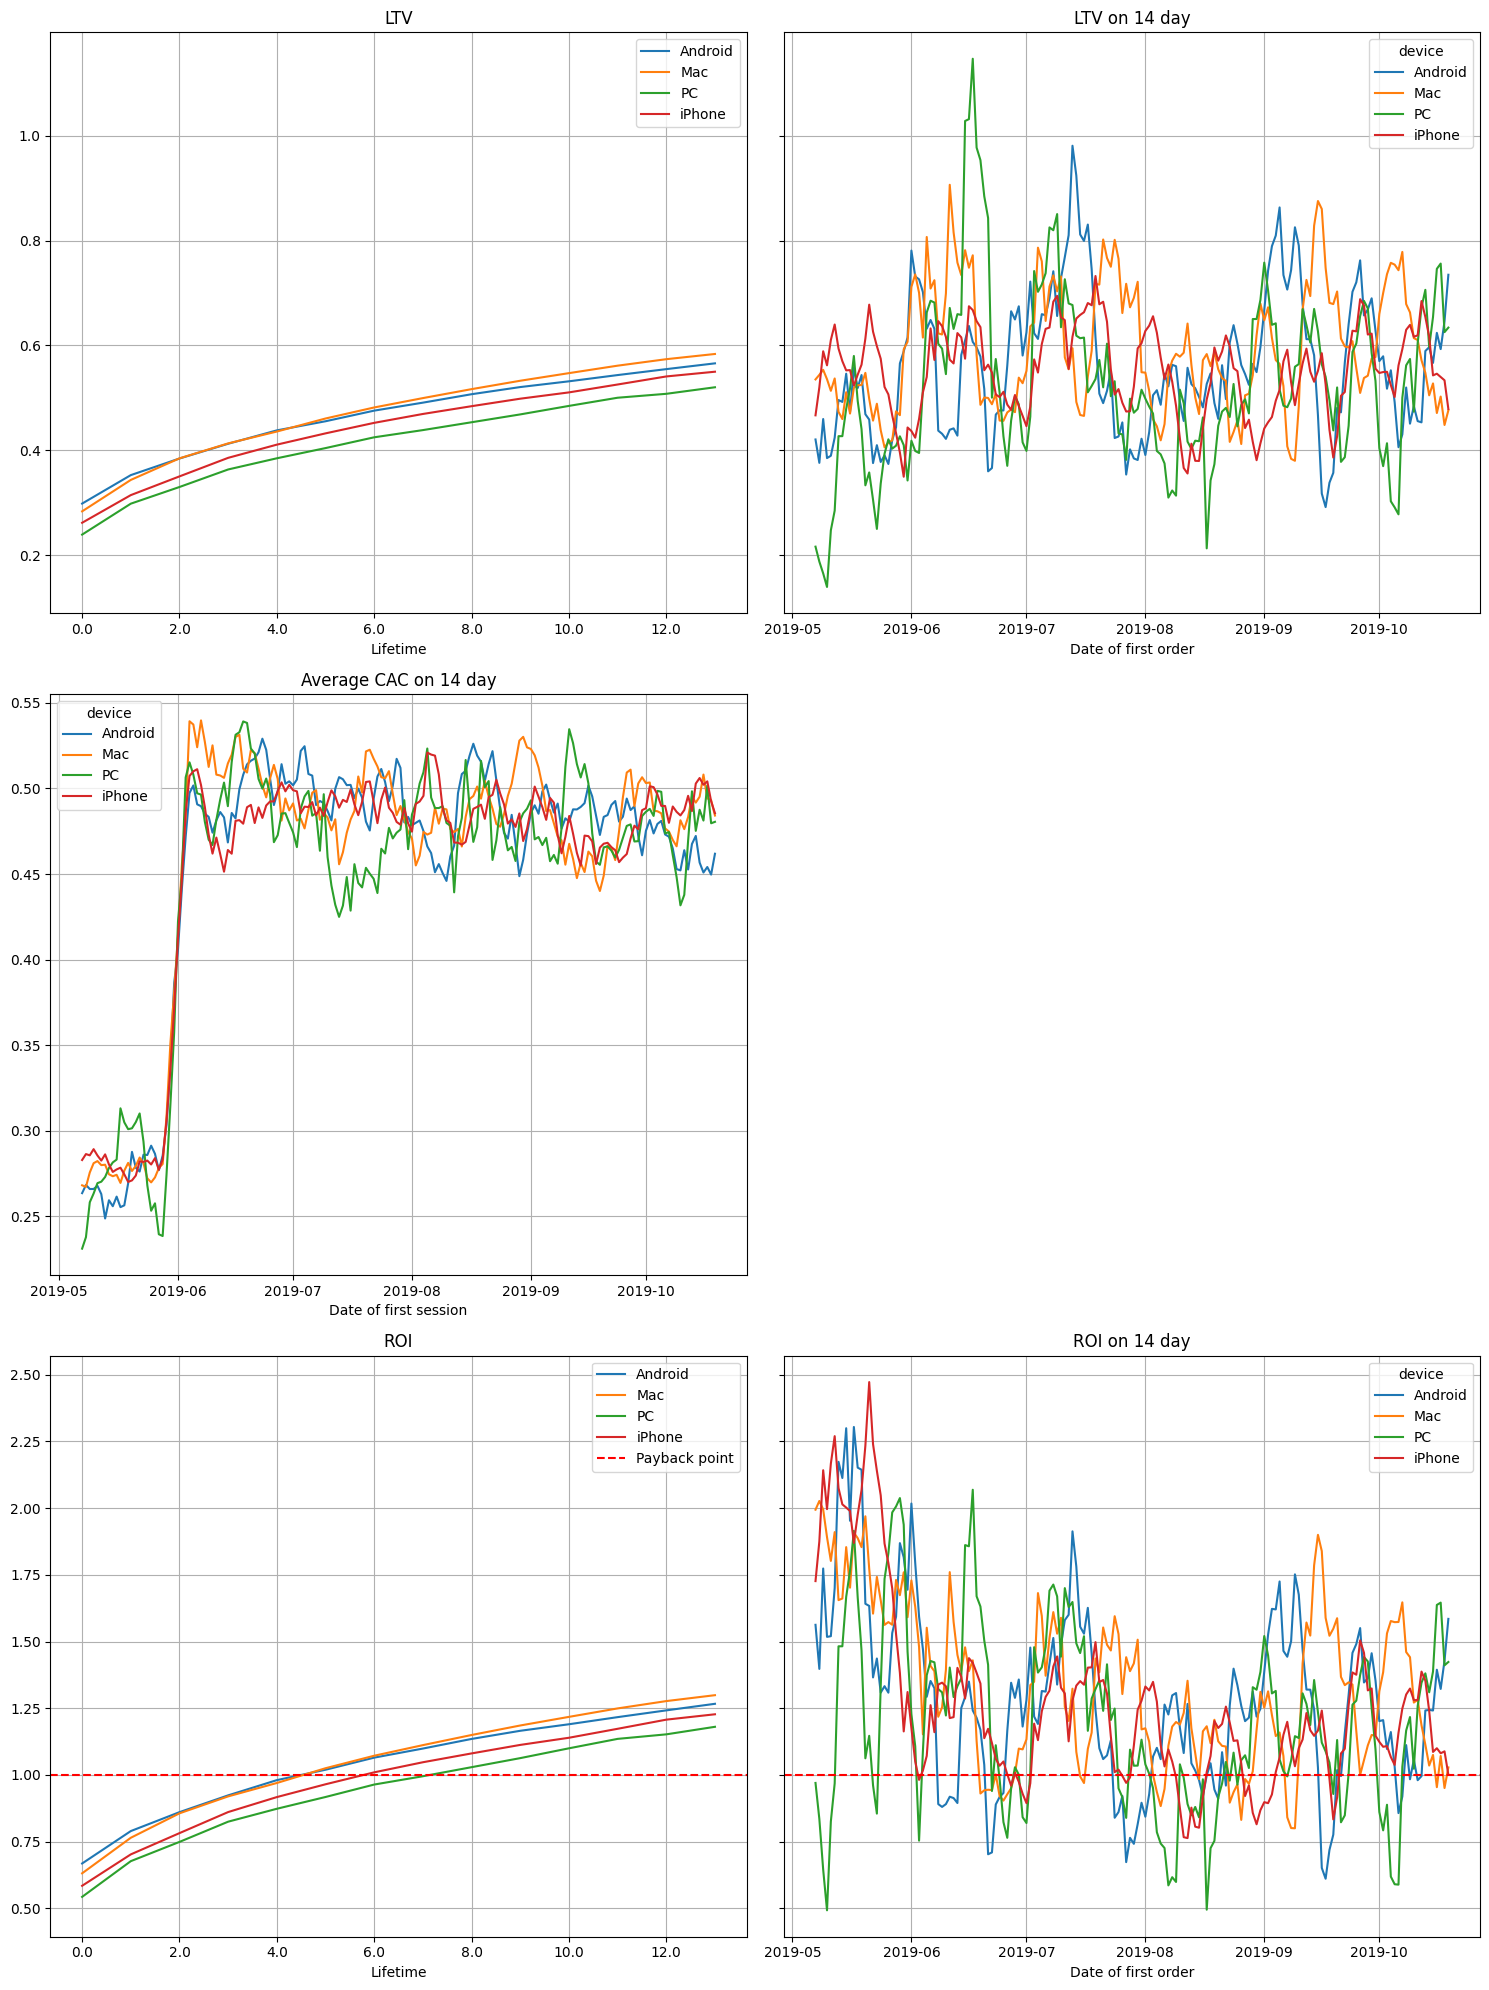

In [137]:
profiles_us_wo_tiptop = profiles_us.query('channel != "TipTop"')

show_plot('ltv_and_roi', ['device'], profiles_df='profiles_us_wo_tiptop')

#### If we are looking at the data without TipTop channel we can make the following conclusions:
- The US market demonstrates a payback period around the 7th to 8th day, indicating improved efficiency without the TipTop channel.
- All devices exhibit comparable performance in terms of both Lifetime Value (LTV) and Customer Acquisition Cost (CAC).
- The increase in CAC around June 2019, amounting to approximately 20%, has had a significant impact on the overall marketing campaign.

___

## 6. Final conclusion and recommendations


#### Conclusions 
1. A significant portion of users and payers originate from the USA. This market stands out both in terms of absolute numbers and relative payers share.
2. Germany and the United Kingdom present promising growth opportunities. The CAC remains reasonable in these markets, while the LTV is favorable.
3. While the organic channel drives substantial traffic without budget investment, its low conversion rate of 2% raises concerns about its effectiveness in generating orders.
4. AdNonSense and LambdaMediaAds channels exhibit notable payers share (~11% and ~10% respectively) with relatively low marketing budgets.
5. The bulk of the marketing budget is allocated to FaceBoom and TipTop channels. Despite TipTop's higher budget, FaceBoom boasts a superior conversion rate.
6. TipTop experienced a significant budget increase over the observation period, resulting in higher CAC compared to FaceBoom due to a lower conversion rate.
7. Despite the majority of users using iPhones, their LTV is the lowest among all devices, whereas PC users exhibit the highest LTV.

#### Summary of the problems:

A central challenge of the marketing campaign lies in budget allocation. A large portion is directed towards the US market, which demonstrates unfavorable LTV results. To address this, the company should consider redistributing the budget to other countries, particularly focusing on Germany and the United Kingdom.

Two key channels, FaceBoom and AdNonSense, display retention issues. Investigating and rectifying these issues, possibly through technical improvements or revised user engagement strategies, is imperative. A similar focus is required for AdNonSense due to its low retention despite strong conversion and CAC metrics. Increasing the budget for the successful LambdaMediaAds channel is advisable.

#### Recommended steps to take:
- Equitably redistribute the marketing budget across countries, emphasizing Germany and the United Kingdom.
- Substantially reduce the TipTop channel's budget.
- Enhance the budget allocation for the LambdaMediaAds channel.
- Investigate FaceBoom and AdNonSense channels to improve their retention rates through enhanced engagement strategies.
- Strive to expand the user base using PC and Android devices.